In [1]:
import numpy as np
import pandas as pd

import xgboost as xgb

from xgboost import XGBClassifier

from datetime import datetime,timedelta

import os
os.chdir('../Python')
from utilities import *
os.chdir('../development')

# Loading data

In [36]:
data = load("../Generated Data/atp_data_f")
features=load("../Generated Data/atp_data_features")
eval_odds=load("../Generated Data/eval_odds")

In [653]:
def get_cals_to_drop(start_date,nb_players,nb_tournaments):
    
    test_beginning_match=data[data.Date>=start_date].index[0] #id of the first match of the testing set
    span_matches=len(data)-test_beginning_match+1
    #duration_val_matches=700 + 10
    duration_val_matches=300 
    duration_train_matches=10400
    #duration_train_matches=12122
    duration_test_matches=500
    
    # Number of matches in our dataset (ie. nb. of outcomes divided by 2)
    nm=int(len(features)/2)

    # Id of the first and last match of the testing,validation,training set
    beg_test=test_beginning_match
    end_test=min(test_beginning_match+duration_test_matches-1,nm-1)
    end_val=min(beg_test-1,nm-1)
    beg_val=beg_test-duration_val_matches
    end_train=beg_val-1
    beg_train=beg_val-duration_train_matches
    
    # We limit the number of players and tournaments one-hot encoded : we'll keep only the 
    # players that won the most matches to avoid overfitting and make the process quicker
    # Biggest players :
    biggest_players=data.iloc[range(beg_train,end_train),:][["Winner","Loser"]]
    biggest_players=pd.concat([biggest_players.Winner,biggest_players.Loser],0)
    biggest_players=list(biggest_players.value_counts().index[:nb_players])
    player_columns=[el for el in xtrain.columns if el[:6]=="player"]
    to_drop_players=[el for el in player_columns if el[7:] not in biggest_players]
    # Biggest Tournaments
    biggest_tournaments=data.iloc[range(beg_train,end_train),:]["Tournament"]
    biggest_tournaments=list(biggest_tournaments.value_counts().index[:nb_tournaments])
    tournament_columns=[el for el in xtrain.columns if el[:10]=="tournament"]
    to_drop_tournaments=[el for el in tournament_columns if el[11:] not in biggest_tournaments]
    
    return to_drop_players, to_drop_tournaments
    

In [654]:
def make_split(days_diff,to_drop_players, to_drop_tournaments, start_date):
    
    
    #start_date=datetime(2016,2,1) #first day of testing set
    test_beginning_match=data[data.Date>=start_date].index[0] #id of the first match of the testing set
    span_matches=len(data)-test_beginning_match+1
    #duration_val_matches=700 + 10
    duration_val_matches=300 + days_diff
    duration_train_matches=10400
    #duration_train_matches=12122
    duration_test_matches=500
    
    # Number of matches in our dataset (ie. nb. of outcomes divided by 2)
    nm=int(len(features)/2)

    # Id of the first and last match of the testing,validation,training set
    beg_test=test_beginning_match
    end_test=min(test_beginning_match+duration_test_matches-1,nm-1)
    end_val=min(beg_test-1,nm-1)
    beg_val=beg_test-duration_val_matches
    end_train=beg_val-1
    beg_train=beg_val-duration_train_matches
    
    global train_indices
    global val_indices
    global test_indices
    global xtest

    train_indices=range(2*beg_train,2*end_train+2)
    val_indices=range(2*beg_val,2*end_val+2)
    test_indices=range(2*beg_test,2*end_test+2)
    


    # Split in train/validation/test
    xval=features.iloc[val_indices,:].reset_index(drop=True)
    xtest=features.iloc[test_indices,:].reset_index(drop=True)
    xtrain=features.iloc[train_indices,:].reset_index(drop=True)
    ytrain=pd.Series([1,0]*int(len(train_indices)/2))
    yval=pd.Series([1,0]*int(len(val_indices)/2))
    
    '''
    # We limit the number of players and tournaments one-hot encoded : we'll keep only the 
    # players that won the most matches to avoid overfitting and make the process quicker
    # Biggest players :
    biggest_players=data.iloc[range(beg_train,end_train),:][["Winner","Loser"]]
    biggest_players=pd.concat([biggest_players.Winner,biggest_players.Loser],0)
    biggest_players=list(biggest_players.value_counts().index[:nb_players])
    player_columns=[el for el in xtrain.columns if el[:6]=="player"]
    to_drop_players=[el for el in player_columns if el[7:] not in biggest_players]
    # Biggest Tournaments
    biggest_tournaments=data.iloc[range(beg_train,end_train),:]["Tournament"]
    biggest_tournaments=list(biggest_tournaments.value_counts().index[:nb_tournaments])
    tournament_columns=[el for el in xtrain.columns if el[:10]=="tournament"]
    to_drop_tournaments=[el for el in tournament_columns if el[11:] not in biggest_tournaments]
    # We drop smallest Tournaments and players
    '''
    xtrain=xtrain.drop(to_drop_players+to_drop_tournaments,1)
    xval=xval.drop(to_drop_players+to_drop_tournaments,1)
    xtest=xtest.drop(to_drop_players+to_drop_tournaments,1)
    
    
    
    
    
    
    return xtrain, ytrain, xval, yval, xtest, train_indices, val_indices, test_indices
    
    #return xtrain, ytrain, xval, yval, xtest


In [14]:
len(train_indices)

24244

In [7]:
xtrain, ytrain, xval, yval, xtest, train_indices, val_indices, test_indices = make_split(5)

In [39]:

## XGB parameters
#learning_rate=[0.295] 
learning_rate=[0.3] 
max_depth=[19]
#max_depth=[10]
min_child_weight=[1]
gamma=[0.8]
csbt=[0.5]
lambd=[0]
alpha=[2]
#alpha=[1]
num_rounds=[300]
early_stop=[10]
params=np.array(np.meshgrid(learning_rate,max_depth,min_child_weight,gamma,csbt,lambd,alpha,num_rounds,early_stop)).T.reshape(-1,9).astype(np.float)
#xgb_params=params[0]
p=params[0]


def evalerror(preds, dtrain):
#thr = 0.5
    #labels = dtrain.get_label()
    global eval_odds
    global train_indices
    global val_indices
    global test_indices


    if len(preds) == len(train_indices):
        odds = eval_odds[train_indices]
        gain = odds * preds       
    elif len(preds) == len(val_indices):
        odds = eval_odds[val_indices]
        gain = odds * preds 
    elif len(preds) == len(test_indices):
        odds = eval_odds[test_indices]
        gain = odds * preds 
    else:
        return 'function_error', 0

    
    #print(preds.shape)
    
    #return 'neg_gain_error', 0

    return 'neg_gain_error', -gain.sum()




dtrain=xgb.DMatrix(xtrain,label=ytrain)

#the_metric = "logloss"
#the_metric = "error"
#the_metric = "auc"
#the_metric = ["error","auc"]
the_metric = 'evalerror'

dval=xgb.DMatrix(xval,label=yval)
eval_set = [(dtrain,"train_loss"),(dval, 'eval')]
#eval_set = [(dval, 'eval')]
#params={'eval_metric':the_metric,"objective":"binary:logistic",'subsample':0.8,
#        'min_child_weight':p[2],'alpha':p[6],'lambda':p[5],'max_depth':int(p[1]),
#        'gamma':p[3],'eta':p[0],'colsample_bytree':p[4]}
#model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))

params={"objective":"binary:logistic",'subsample':0.8,
        'min_child_weight':p[2],'alpha':p[6],'lambda':p[5],'max_depth':int(p[1]),
        'gamma':p[3],'eta':p[0],'colsample_bytree':p[4],  'disable_default_eval_metric' : 1}
#model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]), eval_metric = evalerror)
model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]), feval = evalerror)
#model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))

#model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))


[0]	train_loss-neg_gain_error:-110.61	eval-neg_gain_error:15.8456
Multiple eval metrics have been passed: 'eval-neg_gain_error' will be used for early stopping.

Will train until eval-neg_gain_error hasn't improved in 10 rounds.
[1]	train_loss-neg_gain_error:-570.352	eval-neg_gain_error:12.8859
[2]	train_loss-neg_gain_error:-970.036	eval-neg_gain_error:13.3708
[3]	train_loss-neg_gain_error:-1366.11	eval-neg_gain_error:11.8475
[4]	train_loss-neg_gain_error:-1761.72	eval-neg_gain_error:12.0528
[5]	train_loss-neg_gain_error:-2126.39	eval-neg_gain_error:10.9817
[6]	train_loss-neg_gain_error:-2429.23	eval-neg_gain_error:12.5219
[7]	train_loss-neg_gain_error:-2700.23	eval-neg_gain_error:11.7474
[8]	train_loss-neg_gain_error:-2948.49	eval-neg_gain_error:10.5577
[9]	train_loss-neg_gain_error:-3167.83	eval-neg_gain_error:9.65078
[10]	train_loss-neg_gain_error:-3371.46	eval-neg_gain_error:8.85426
[11]	train_loss-neg_gain_error:-3588.64	eval-neg_gain_error:9.93691
[12]	train_loss-neg_gain_error:-

In [891]:
def get_trained_model(days_diff,to_drop_players, to_drop_tournaments,start_date):
    xtrain, ytrain, xval, yval, xtest, train_indices, val_indices, test_indices = make_split(days_diff,to_drop_players, to_drop_tournaments,start_date)
    
    global p
    
    ## XGB parameters
    #learning_rate=[0.295] 
    learning_rate=[0.18] 
    #max_depth=[19]
    #max_depth=[10]
    max_depth=[22]
    min_child_weight=[5]
    gamma=[0.8]
    csbt=[0.5]
    lambd=[0]
    alpha=[2]
    #alpha=[1]
    num_rounds=[300]
    early_stop=[7]
    params=np.array(np.meshgrid(learning_rate,max_depth,min_child_weight,gamma,csbt,lambd,alpha,num_rounds,early_stop)).T.reshape(-1,9).astype(np.float)
    #xgb_params=params[0]
    p=params[0]


    def evalerror_inner(preds_in, dtrain):
        thr = 0.62
        #labels = dtrain.get_label()
        global eval_odds
        global train_indices
        global val_indices
        global test_indices
        
        preds_dec = np.zeros(len(preds_in))
        
        for k in range(0,len(preds_in)-1,2):
            if preds_in[k]>preds_in[k+1]:
                preds_dec[k] = preds_in[k]
                preds_dec[k+1] = 0
            else:
                preds_dec[k] = 0
                preds_dec[k+1] = preds_in[k+1]
        
        preds = np.array([1 if p_i>=thr else 0 for p_i in preds_dec])
        
        #print(f'Preds1 {preds_in[0:10]}')
        #print(f'Preds1 {preds_dec[0:10]}')
        #print(f'Preds1 {preds[0:10]}')


        if len(preds) == len(train_indices):
            odds = eval_odds[train_indices]
            gain = odds * preds       
            reachable = odds.sum()+(len(train_indices)/2)
            current_roi = round(gain.sum()/preds.sum(),3)
            print(f'Max reachable train loss: {-reachable} Train ROI: {current_roi}% Number of bets: {preds.sum()}')
            return 'train_gain_error', -gain.sum()
        elif len(preds) == len(val_indices):
            odds = eval_odds[val_indices]
            gain = odds * preds 
            reachable = odds.sum()+(len(val_indices)/2)
            current_roi = round(gain.sum()/preds.sum(),3)
            print(f'Max reachable eval  loss: {-reachable}  Eval ROI: {current_roi}% Number of bets: {preds.sum()}')
            print(f'Val Preds {preds[0:10]} Threshold: {thr}')
            return 'val_gain_error', -gain.sum()
        elif len(preds) == len(test_indices):
            odds = eval_odds[test_indices]
            gain = odds * preds 
            return 'test_gain_error', -gain.sum()
        else:
            return 'function_error', 0


        #print(preds.shape)

        #return 'neg_gain_error', 0

        #return 'neg_gain_error', -gain.sum()
        
    #xtrain.drop(['odds', 'odds_opp'], axis = 1, inplace = True)
    #xval.drop(['odds', 'odds_opp'], axis = 1,inplace = True)
    #xtest.drop(['odds', 'odds_opp'], axis = 1,inplace = True)



    dtrain=xgb.DMatrix(xtrain,label=ytrain)

    the_metric = "logloss"
    #the_metric = "error"
    #the_metric = "auc"
    #the_metric = ["error","auc"]
    #the_metric = 'evalerror'
    

    dval=xgb.DMatrix(xval,label=yval)
    eval_set = [(dtrain,"train_loss"),(dval, 'eval')]
    #eval_set = [(dval, 'eval')]
    #params={'eval_metric':the_metric,"objective":"binary:logistic",'subsample':0.8,
    #        'min_child_weight':p[2],'alpha':p[6],'lambda':p[5],'max_depth':int(p[1]),
    #        'gamma':p[3],'eta':p[0],'colsample_bytree':p[4],  'disable_default_eval_metric' : 0}
    #model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))

    params={"objective":"binary:logistic",'subsample':0.8,
            'min_child_weight':p[2],'alpha':p[6],'lambda':p[5],'max_depth':int(p[1]),
            'gamma':p[3],'eta':p[0],'colsample_bytree':p[4],  'disable_default_eval_metric' : 1}
    #model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]), eval_metric = evalerror)
    model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]), feval = evalerror_inner)
    #model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))

    #model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))
    
    eval_predict = model.predict(dval)
    evalscore = evalerror_inner(eval_predict,dtrain)

    return model, train_indices, val_indices, test_indices , xtest, evalscore[1]

In [865]:
p

array([2.95e-01, 5.00e+01, 1.00e+00, 8.00e-01, 5.00e-01, 0.00e+00,
       2.00e+00, 3.00e+02, 1.50e+01])

In [699]:
start_date=datetime(2017,5,1) #first day of testing set

to_drop_players, to_drop_tournaments= get_cals_to_drop(start_date,200,200)
    
    


model1, train_indices, val_indices, test_indices, xtest, evalscore1 = get_trained_model(0,to_drop_players, to_drop_tournaments,start_date)
model2, train_indices, val_indices, test_indices, xtest, evalscore2 = get_trained_model(10,to_drop_players, to_drop_tournaments,start_date)
model3, train_indices, val_indices, test_indices, xtest, evalscore3 = get_trained_model(-10,to_drop_players, to_drop_tournaments,start_date)
model4, train_indices, val_indices, test_indices, xtest, evalscore4 = get_trained_model(30,to_drop_players, to_drop_tournaments,start_date)
model5, train_indices, val_indices, test_indices, xtest, evalscore5 = get_trained_model(-30,to_drop_players, to_drop_tournaments,start_date)
model6, train_indices, val_indices, test_indices, xtest, evalscore6 = get_trained_model(45,to_drop_players, to_drop_tournaments,start_date)
model7, train_indices, val_indices, test_indices, xtest, evalscore7 = get_trained_model(-45,to_drop_players, to_drop_tournaments,start_date)
model8, train_indices, val_indices, test_indices, xtest, evalscore8 = get_trained_model(17,to_drop_players, to_drop_tournaments,start_date)
model9, train_indices, val_indices, test_indices, xtest, evalscore9 = get_trained_model(-17,to_drop_players, to_drop_tournaments,start_date)



clf_list = [model1, model2, model3, model4, model5, model6, model7, model8, model9]
classif = VotingClassifier(clf_list)
xtest_0=features.iloc[test_indices,:].reset_index(drop=True)
#Y, K, KT, y_mean_pr, y_mean, Y_voting, y_voting, deci, y_mean_pr_conf, y_mean_conf= classif.predict(xtest, 0.7, vote_thr = (7/9))
y_mean,  y_voting, y_mean_pr_conf, y_mean_conf, y_voting_conf = classif.predict(xtest, 0.7, vote_thr = (7/9), conf_thr = 0.7)


print(evalerror(y_voting, dtrain))
print(evalerror(y_mean, dtrain))
print(evalerror(y_mean_conf, dtrain))
print(evalerror(y_voting_conf, dtrain))

Preds1 [0.5        0.5        0.57665277 0.5        0.4598593  0.5
 0.5        0.5587277  0.5909254  0.40320414]
Preds1 [0.         0.5        0.57665277 0.         0.         0.5
 0.         0.55872768 0.5909254  0.        ]
Preds1 [0 1 1 0 0 1 0 1 1 0]
Max reachable train loss: -9713.19 Train ROI: 0.161% Number of bets: 10052
Preds1 [0.5628796  0.43335354 0.39928108 0.601807   0.47894102 0.6013785
 0.5732198  0.45795664 0.6021436  0.40320414]
Preds1 [0.56287962 0.         0.         0.601807   0.         0.6013785
 0.57321978 0.         0.60214359 0.        ]
Preds1 [1 0 0 1 0 1 1 0 1 0]
Max reachable eval  loss: -312.36  Eval ROI: -0.03% Number of bets: 282
Val Preds [1 0 0 1 0 1 1 0 1 0] Threshold: 0.5
[0]	train_loss-train_gain_error:-1618.48	eval-val_gain_error:8.53
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Preds1 [0.5        0.5        0.63421375 0.3984463  0.51

KeyboardInterrupt: 

In [892]:
res =[]
for i in range(2014,2017,1):
    for j in range(1,13):
        start_date=datetime(i,j,1) #first day of testing set
        print(start_date)

        to_drop_players, to_drop_tournaments= get_cals_to_drop(start_date,50,5)
        
        
        threshold_test = 0.62
        threshold_test_conf = 0.62
        req_votes = 9/9
        threshold_test_log_odd = 1.35
        
        threshold_train = 0.62 # !!! Not passed to function, just for saving info!
    


        model1, train_indices, val_indices, test_indices, xtest, evalscore1 = get_trained_model(0,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model2, train_indices, val_indices, test_indices, xtest, evalscore2 = get_trained_model(10,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model3, train_indices, val_indices, test_indices, xtest, evalscore3 = get_trained_model(-10,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model4, train_indices, val_indices, test_indices, xtest, evalscore4 = get_trained_model(30,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model5, train_indices, val_indices, test_indices, xtest, evalscore5 = get_trained_model(-30,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model6, train_indices, val_indices, test_indices, xtest, evalscore6 = get_trained_model(45,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model7, train_indices, val_indices, test_indices, xtest, evalscore7 = get_trained_model(-45,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model8, train_indices, val_indices, test_indices, xtest, evalscore8 = get_trained_model(17,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model9, train_indices, val_indices, test_indices, xtest, evalscore9 = get_trained_model(-17,to_drop_players, to_drop_tournaments,start_date)



        clf_list = [model1, model2, model3, model4, model5, model6, model7, model8, model9]
        classif = VotingClassifier(clf_list)
        xtest_0=features.iloc[test_indices,:].reset_index(drop=True)
        #Y, K, KT, y_mean_pr, y_mean, Y_voting, y_voting, deci, y_mean_pr_conf, y_mean_conf= classif.predict(xtest, 0.7, vote_thr = (7/9))
        #y_mean,  y_voting, y_mean_pr_conf, y_mean_conf, y_voting_conf = classif.predict(xtest, threshold_test, vote_thr = req_votes, conf_thr = threshold_test_conf)
        y_mean,  y_voting, y_mean_conf, y_voting_conf, y_mean_log_odd, y_voting_log_odd = classif.predict(xtest, threshold_test, vote_thr = req_votes, conf_thr = threshold_test_conf, log_odd_thr = threshold_test_log_odd)
        result = [start_date, evalerror(y_voting, dtrain), evalerror(y_mean, dtrain),evalerror(y_voting_conf, dtrain), evalerror(y_mean_conf, dtrain), evalerror(y_voting_log_odd, dtrain), evalerror(y_mean_log_odd, dtrain), y_voting.sum(), y_mean.sum(), y_voting_conf.sum(),y_mean_conf.sum(), y_voting_log_odd.sum(),y_mean_log_odd.sum()]
        
        res.append(result)
        
        print(f'y_voting:         {evalerror(y_voting, dtrain)[1]}')
        print(f'y_mean:           {evalerror(y_mean, dtrain)[1]}')
        print(f'y_voting_conf:    {evalerror(y_voting_conf, dtrain)[1]}')
        print(f'y_mean_conf:      {evalerror(y_mean_conf, dtrain)[1]}')
        print(f'y_voting_log_odd: {evalerror(y_voting_log_odd, dtrain)[1]}')
        print(f'y_mean_log_odd:   {evalerror(y_mean_log_odd, dtrain)[1]}')

        res_cols = 6
        
        f1 = np.zeros((len(res),res_cols))
        f2 = np.zeros((len(res),res_cols))
        for r in range(res_cols):
            f1[:,r] = np.array([row[r+1][1] for row in res])
            f2[:,r] = f1[:,r].cumsum()
        
        print(f1)
        print(f2)
#post_fix = "_test6" nicht nochmal
comments = 'nb_players = 30, nb_turnaments = 7'
post_fix = "_test12_drop_"      

para_str = "train_test_results" + post_fix + "_info"
res_str = "train_test_results" + post_fix
parameters = [threshold_test, threshold_test_conf, req_votes,threshold_test_log_odd, threshold_train, p, comments]        
dump(parameters,para_str)
dump(res,res_str)

2014-01-01 00:00:00


/opt/anaconda3/envs/nf/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Max reachable train loss: -9561.1 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -271.94  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9561.1 Train ROI: 0.032% Number of bets: 1814
Max reachable eval  loss: -271.94  Eval ROI: 0.003% Number of bets: 36
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-58.292	eval-val_gain_error:-0.11


/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars


Max reachable train loss: -9561.1 Train ROI: 0.128% Number of bets: 3748
Max reachable eval  loss: -271.94  Eval ROI: -0.054% Number of bets: 94
Val Preds [0 1 0 0 0 0 1 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-480.086	eval-val_gain_error:5.09
Max reachable train loss: -9561.1 Train ROI: 0.155% Number of bets: 4981
Max reachable eval  loss: -271.94  Eval ROI: -0.018% Number of bets: 143
Val Preds [0 1 0 0 0 1 1 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-770.551	eval-val_gain_error:2.51
Max reachable train loss: -9561.1 Train ROI: 0.179% Number of bets: 5545
Max reachable eval  loss: -271.94  Eval ROI: -0.029% Number of bets: 158
Val Preds [0 1 0 0 0 1 1 0 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-992.264	eval-val_gain_error:4.63
Max reachable train loss: -9561.1 Train ROI: 0.201% Number of bets: 6141
Max reachable eval  loss: -271.94  Eval ROI: -0.029% Number of bets: 175
Val Preds [0 1 0 0 0 1 1 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_e

Max reachable train loss: -9565.04 Train ROI: 0.301% Number of bets: 7667
Max reachable eval  loss: -258.0  Eval ROI: -0.027% Number of bets: 198
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[12]	train_loss-train_gain_error:-2310.83	eval-val_gain_error:5.29
Max reachable train loss: -9565.04 Train ROI: 0.312% Number of bets: 7790
Max reachable eval  loss: -258.0  Eval ROI: -0.013% Number of bets: 200
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[13]	train_loss-train_gain_error:-2433.73	eval-val_gain_error:2.53
Max reachable train loss: -9565.04 Train ROI: 0.325% Number of bets: 7889
Max reachable eval  loss: -258.0  Eval ROI: 0.0% Number of bets: 194
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[14]	train_loss-train_gain_error:-2566.32	eval-val_gain_error:-0.06
Stopping. Best iteration:
[7]	train_loss-train_gain_error:-1517.19	eval-val_gain_error:-2.25

Max reachable eval  loss: -258.0  Eval ROI: 0.0% Number of bets: 194
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
2014-01-

Max reachable train loss: -9559.82 Train ROI: 0.332% Number of bets: 7913
Max reachable eval  loss: -243.22  Eval ROI: 0.039% Number of bets: 179
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.62
[14]	train_loss-train_gain_error:-2625.78	eval-val_gain_error:-6.95
Max reachable train loss: -9559.82 Train ROI: 0.345% Number of bets: 8027
Max reachable eval  loss: -243.22  Eval ROI: 0.034% Number of bets: 181
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.62
[15]	train_loss-train_gain_error:-2765.84	eval-val_gain_error:-6.09
Max reachable train loss: -9559.82 Train ROI: 0.361% Number of bets: 8134
Max reachable eval  loss: -243.22  Eval ROI: 0.021% Number of bets: 181
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.62
[16]	train_loss-train_gain_error:-2937.19	eval-val_gain_error:-3.89
Max reachable train loss: -9559.82 Train ROI: 0.371% Number of bets: 8216
Max reachable eval  loss: -243.22  Eval ROI: 0.024% Number of bets: 180
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.62
[17]	train_loss-trai

Max reachable train loss: -9557.69 Train ROI: 0.316% Number of bets: 7847
Max reachable eval  loss: -230.35000000000002  Eval ROI: -0.014% Number of bets: 176
Val Preds [1 0 0 0 0 1 1 0 0 0] Threshold: 0.62
[13]	train_loss-train_gain_error:-2476.86	eval-val_gain_error:2.54
Max reachable train loss: -9557.69 Train ROI: 0.325% Number of bets: 7927
Max reachable eval  loss: -230.35000000000002  Eval ROI: 0.015% Number of bets: 176
Val Preds [1 0 0 0 0 1 1 0 0 0] Threshold: 0.62
[14]	train_loss-train_gain_error:-2577.43	eval-val_gain_error:-2.63
Max reachable train loss: -9557.69 Train ROI: 0.339% Number of bets: 8031
Max reachable eval  loss: -230.35000000000002  Eval ROI: 0.021% Number of bets: 184
Val Preds [1 0 0 0 0 1 1 0 0 0] Threshold: 0.62
[15]	train_loss-train_gain_error:-2718.69	eval-val_gain_error:-3.82
Max reachable train loss: -9557.69 Train ROI: 0.353% Number of bets: 8104
Max reachable eval  loss: -230.35000000000002  Eval ROI: 0.007% Number of bets: 187
Val Preds [1 0 0 0 0

Max reachable train loss: -9562.35 Train ROI: 0.203% Number of bets: 6586
Max reachable eval  loss: -253.69  Eval ROI: -0.012% Number of bets: 169
Val Preds [0 1 0 0 0 0 1 0 0 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1336.88	eval-val_gain_error:1.95
Max reachable train loss: -9562.35 Train ROI: 0.221% Number of bets: 6920
Max reachable eval  loss: -253.69  Eval ROI: -0.003% Number of bets: 175
Val Preds [0 1 0 0 0 0 1 0 0 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1526.86	eval-val_gain_error:0.44
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0

Max reachable eval  loss: -253.69  Eval ROI: -0.003% Number of bets: 175
Val Preds [0 1 0 0 0 0 1 0 0 0] Threshold: 0.62
y_voting:         5.230000000000001
y_mean:           18.21
y_voting_conf:    2.419999999999999
y_mean_conf:      4.740000000000001
y_voting_log_odd: 8.0
y_mean_log_odd:   8.0
[[ 5.23 18.21  2.42  4.74  8.    8.  ]]
[[ 5.23 18.21  2.42  4.74  8.    8.  ]]
2014-02-01 00:00

Stopping. Best iteration:
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0

Max reachable eval  loss: -273.59000000000003  Eval ROI: -0.06% Number of bets: 184
Val Preds [0 0 1 0 0 0 0 0 1 0] Threshold: 0.62
2014-02-01 00:00:00
Max reachable train loss: -9574.803 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -314.87  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9574.803 Train ROI: 0.016% Number of bets: 1336
Max reachable eval  loss: -314.87  Eval ROI: 0.014% Number of bets: 47
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-20.714	eval-val_gain_error:-0.65
Max reachable train loss: -9574.803 Train ROI: 0.119% Number of bets: 3665
Max reachable eval  lo

Max reachable train loss: -9583.131 Train ROI: 0.277% Number of bets: 7387
Max reachable eval  loss: -323.07  Eval ROI: -0.05% Number of bets: 231
Val Preds [1 0 0 0 1 0 1 0 0 0] Threshold: 0.62
[10]	train_loss-train_gain_error:-2048.27	eval-val_gain_error:11.52
Stopping. Best iteration:
[3]	train_loss-train_gain_error:-703.241	eval-val_gain_error:-0.79

Max reachable eval  loss: -323.07  Eval ROI: -0.05% Number of bets: 231
Val Preds [1 0 0 0 1 0 1 0 0 0] Threshold: 0.62
2014-02-01 00:00:00
Max reachable train loss: -9576.065 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -247.87  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9576.065 Train ROI: 0.022% Number of bets: 1646
Max reachable eval  lo

Max reachable train loss: -9609.251 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -252.14999999999998  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9609.251 Train ROI: 0.017% Number of bets: 1355
Max reachable eval  loss: -252.14999999999998  Eval ROI: 0.019% Number of bets: 29
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-22.73	eval-val_gain_error:-0.56
Max reachable train loss: -9609.251 Train ROI: 0.12% Number of bets: 3744
Max reachable eval  loss: -252.14999999999998  Eval ROI: 0.005% Number of bets: 100
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-447.664	eval-val_gain_error:-0.5
Max reachable train loss: -9609.251 Tra

Max reachable train loss: -9609.028 Train ROI: 0.205% Number of bets: 6518
Max reachable eval  loss: -239.45  Eval ROI: 0.001% Number of bets: 162
Val Preds [0 1 1 0 1 0 0 0 0 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1337.88	eval-val_gain_error:-0.22
Max reachable train loss: -9609.028 Train ROI: 0.221% Number of bets: 6826
Max reachable eval  loss: -239.45  Eval ROI: -0.022% Number of bets: 174
Val Preds [0 1 1 0 1 0 0 0 0 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1508.36	eval-val_gain_error:3.9
Max reachable train loss: -9609.028 Train ROI: 0.242% Number of bets: 7061
Max reachable eval  loss: -239.45  Eval ROI: 0.005% Number of bets: 178
Val Preds [0 1 1 0 1 0 0 0 0 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1708.08	eval-val_gain_error:-0.81
Max reachable train loss: -9609.028 Train ROI: 0.256% Number of bets: 7243
Max reachable eval  loss: -239.45  Eval ROI: 0.046% Number of bets: 186
Val Preds [0 1 1 0 1 0 1 0 0 0] Threshold: 0.62
[9]	train_loss-train

Max reachable train loss: -9616.533 Train ROI: 0.175% Number of bets: 5558
Max reachable eval  loss: -220.52  Eval ROI: -0.046% Number of bets: 133
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-970.483	eval-val_gain_error:6.09
Max reachable train loss: -9616.533 Train ROI: 0.19% Number of bets: 6200
Max reachable eval  loss: -220.52  Eval ROI: -0.015% Number of bets: 142
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1179.65	eval-val_gain_error:2.14
Max reachable train loss: -9616.533 Train ROI: 0.204% Number of bets: 6577
Max reachable eval  loss: -220.52  Eval ROI: -0.051% Number of bets: 153
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1340.41	eval-val_gain_error:7.84
Max reachable train loss: -9616.533 Train ROI: 0.218% Number of bets: 6866
Max reachable eval  loss: -220.52  Eval ROI: -0.039% Number of bets: 153
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[7]	train_loss-trai

Max reachable train loss: -9611.567 Train ROI: 0.151% Number of bets: 5022
Max reachable eval  loss: -268.98  Eval ROI: -0.029% Number of bets: 126
Val Preds [1 0 0 0 1 0 1 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-759.885	eval-val_gain_error:3.6
Max reachable train loss: -9611.567 Train ROI: 0.179% Number of bets: 5550
Max reachable eval  loss: -268.98  Eval ROI: -0.001% Number of bets: 148
Val Preds [0 0 0 0 1 0 1 0 0 1] Threshold: 0.62
[4]	train_loss-train_gain_error:-994.39	eval-val_gain_error:0.13
Max reachable train loss: -9611.567 Train ROI: 0.198% Number of bets: 6143
Max reachable eval  loss: -268.98  Eval ROI: -0.006% Number of bets: 162
Val Preds [1 0 0 0 1 0 1 0 0 1] Threshold: 0.62
[5]	train_loss-train_gain_error:-1215.18	eval-val_gain_error:1.04
Max reachable train loss: -9611.567 Train ROI: 0.214% Number of bets: 6497
Max reachable eval  loss: -268.98  Eval ROI: -0.03% Number of bets: 175
Val Preds [1 0 0 0 1 0 1 0 0 1] Threshold: 0.62
[6]	train_loss-train_

Max reachable train loss: -9600.846 Train ROI: 0.115% Number of bets: 3871
Max reachable eval  loss: -271.23  Eval ROI: -0.013% Number of bets: 118
Val Preds [0 0 1 0 0 0 0 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-446.945	eval-val_gain_error:1.54
Max reachable train loss: -9600.846 Train ROI: 0.145% Number of bets: 5046
Max reachable eval  loss: -271.23  Eval ROI: 0.029% Number of bets: 152
Val Preds [0 0 1 0 0 0 0 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-731.526	eval-val_gain_error:-4.43
Max reachable train loss: -9600.846 Train ROI: 0.169% Number of bets: 5568
Max reachable eval  loss: -271.23  Eval ROI: 0.026% Number of bets: 165
Val Preds [0 1 1 0 0 0 0 0 0 1] Threshold: 0.62
[4]	train_loss-train_gain_error:-939.33	eval-val_gain_error:-4.31
Max reachable train loss: -9600.846 Train ROI: 0.198% Number of bets: 6140
Max reachable eval  loss: -271.23  Eval ROI: 0.053% Number of bets: 174
Val Preds [0 1 1 0 0 0 0 0 0 1] Threshold: 0.62
[5]	train_loss-train

Stopping. Best iteration:
[1]	train_loss-train_gain_error:-67.623	eval-val_gain_error:-2.03

Max reachable eval  loss: -287.27  Eval ROI: -0.032% Number of bets: 218
Val Preds [1 0 0 1 0 0 1 0 0 0] Threshold: 0.62
2014-04-01 00:00:00
Max reachable train loss: -9594.487 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -234.71  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9594.487 Train ROI: 0.012% Number of bets: 1431
Max reachable eval  loss: -234.71  Eval ROI: 0.038% Number of bets: 44
Val Preds [0 0 0 0 0 0 0 0 0 1] Threshold: 0.62
[1]	train_loss-train_gain_error:-17.144	eval-val_gain_error:-1.66
Max reachable train loss: -9594.487 Train ROI: 0.102% Number of bets: 3905
Max reachable eval  loss:

Max reachable train loss: -9606.192 Train ROI: 0.407% Number of bets: 8333
Max reachable eval  loss: -298.35  Eval ROI: 0.04% Number of bets: 247
Val Preds [0 1 1 0 1 0 0 0 1 0] Threshold: 0.62
[20]	train_loss-train_gain_error:-3392.63	eval-val_gain_error:-9.87
Max reachable train loss: -9606.192 Train ROI: 0.415% Number of bets: 8374
Max reachable eval  loss: -298.35  Eval ROI: 0.028% Number of bets: 242
Val Preds [0 1 1 0 1 0 0 0 1 0] Threshold: 0.62
[21]	train_loss-train_gain_error:-3476.47	eval-val_gain_error:-6.68
Max reachable train loss: -9606.192 Train ROI: 0.428% Number of bets: 8432
Max reachable eval  loss: -298.35  Eval ROI: 0.043% Number of bets: 253
Val Preds [0 1 1 0 1 0 0 0 1 0] Threshold: 0.62
[22]	train_loss-train_gain_error:-3611.24	eval-val_gain_error:-10.98
Max reachable train loss: -9606.192 Train ROI: 0.439% Number of bets: 8462
Max reachable eval  loss: -298.35  Eval ROI: 0.035% Number of bets: 247
Val Preds [0 1 1 0 1 0 0 0 0 0] Threshold: 0.62
[23]	train_loss-

Stopping. Best iteration:
[2]	train_loss-train_gain_error:-450.778	eval-val_gain_error:-3.59

Max reachable eval  loss: -279.67  Eval ROI: -0.052% Number of bets: 206
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.62
2014-04-01 00:00:00
Max reachable train loss: -9599.208 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -244.74  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9599.208 Train ROI: 0.036% Number of bets: 1709
Max reachable eval  loss: -244.74  Eval ROI: 0.031% Number of bets: 50
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-60.819	eval-val_gain_error:-1.56
Max reachable train loss: -9599.208 Train ROI: 0.112% Number of bets: 3875
Max reachable eval  loss

Max reachable train loss: -9580.649 Train ROI: 0.147% Number of bets: 4953
Max reachable eval  loss: -293.05  Eval ROI: -0.061% Number of bets: 147
Val Preds [1 0 1 0 0 0 0 0 0 1] Threshold: 0.62
[3]	train_loss-train_gain_error:-728.059	eval-val_gain_error:8.99
Max reachable train loss: -9580.649 Train ROI: 0.169% Number of bets: 5528
Max reachable eval  loss: -293.05  Eval ROI: -0.034% Number of bets: 156
Val Preds [1 0 1 0 0 0 0 0 0 1] Threshold: 0.62
[4]	train_loss-train_gain_error:-936.174	eval-val_gain_error:5.33
Max reachable train loss: -9580.649 Train ROI: 0.194% Number of bets: 6105
Max reachable eval  loss: -293.05  Eval ROI: -0.054% Number of bets: 171
Val Preds [1 0 1 0 0 0 0 0 0 1] Threshold: 0.62
[5]	train_loss-train_gain_error:-1185.05	eval-val_gain_error:9.24
Max reachable train loss: -9580.649 Train ROI: 0.21% Number of bets: 6610
Max reachable eval  loss: -293.05  Eval ROI: -0.065% Number of bets: 187
Val Preds [1 0 1 0 0 0 0 0 0 1] Threshold: 0.62
[6]	train_loss-trai

Max reachable train loss: -9582.0 Train ROI: 0.137% Number of bets: 5106
Max reachable eval  loss: -259.21  Eval ROI: -0.015% Number of bets: 131
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-700.1	eval-val_gain_error:1.96
Max reachable train loss: -9582.0 Train ROI: 0.169% Number of bets: 5636
Max reachable eval  loss: -259.21  Eval ROI: -0.014% Number of bets: 139
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-951.26	eval-val_gain_error:1.91
Max reachable train loss: -9582.0 Train ROI: 0.195% Number of bets: 6141
Max reachable eval  loss: -259.21  Eval ROI: 0.014% Number of bets: 158
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1195.21	eval-val_gain_error:-2.19
Max reachable train loss: -9582.0 Train ROI: 0.208% Number of bets: 6566
Max reachable eval  loss: -259.21  Eval ROI: -0.006% Number of bets: 168
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.62
[6]	train_loss-train_gain_err

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9581.965 Train ROI: 0.032% Number of bets: 1383
Max reachable eval  loss: -296.72999999999996  Eval ROI: -0.008% Number of bets: 37
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-44.411	eval-val_gain_error:0.29
Max reachable train loss: -9581.965 Train ROI: 0.118% Number of bets: 3611
Max reachable eval  loss: -296.72999999999996  Eval ROI: 0.052% Number of bets: 91
Val Preds [0 0 0 0 0 0 0 0 1 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-424.808	eval-val_gain_error:-4.76
Max reachable train loss: -9581.965 Train ROI: 0.148% Number of bets: 4986
Max reachable eval  loss: -296.72999999999996  Eval ROI: 0.012% Number of bets: 141
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-737.645	eval-val_gain_error:-1.75
Max reachable train

Stopping. Best iteration:
[1]	train_loss-train_gain_error:-61.84	eval-val_gain_error:-0.81

Max reachable eval  loss: -262.46  Eval ROI: -0.018% Number of bets: 203
Val Preds [0 1 0 1 1 0 1 0 0 0] Threshold: 0.62
2014-06-01 00:00:00
Max reachable train loss: -9588.67 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -270.63  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9588.67 Train ROI: 0.017% Number of bets: 1619
Max reachable eval  loss: -270.63  Eval ROI: 0.019% Number of bets: 52
Val Preds [0 0 0 0 0 0 0 0 1 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-28.03	eval-val_gain_error:-0.99
Max reachable train loss: -9588.67 Train ROI: 0.119% Number of bets: 3788
Max reachable eval  loss: -270

Max reachable train loss: -9583.75 Train ROI: 0.393% Number of bets: 8282
Max reachable eval  loss: -252.59  Eval ROI: 0.004% Number of bets: 225
Val Preds [0 1 1 0 1 0 0 0 1 0] Threshold: 0.62
[20]	train_loss-train_gain_error:-3252.23	eval-val_gain_error:-0.99
Max reachable train loss: -9583.75 Train ROI: 0.402% Number of bets: 8317
Max reachable eval  loss: -252.59  Eval ROI: 0.006% Number of bets: 224
Val Preds [0 1 1 0 1 0 0 0 1 0] Threshold: 0.62
[21]	train_loss-train_gain_error:-3346.59	eval-val_gain_error:-1.42
Max reachable train loss: -9583.75 Train ROI: 0.415% Number of bets: 8373
Max reachable eval  loss: -252.59  Eval ROI: 0.005% Number of bets: 226
Val Preds [0 1 1 0 1 0 0 0 1 0] Threshold: 0.62
[22]	train_loss-train_gain_error:-3471.85	eval-val_gain_error:-1.24
Stopping. Best iteration:
[15]	train_loss-train_gain_error:-2678.14	eval-val_gain_error:-3.67

Max reachable eval  loss: -252.59  Eval ROI: 0.005% Number of bets: 226
Val Preds [0 1 1 0 1 0 0 0 1 0] Threshold: 0.62

Max reachable train loss: -9587.39 Train ROI: 0.238% Number of bets: 7001
Max reachable eval  loss: -231.48  Eval ROI: 0.011% Number of bets: 177
Val Preds [0 0 0 0 1 0 1 0 1 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1669.32	eval-val_gain_error:-1.88
Max reachable train loss: -9587.39 Train ROI: 0.263% Number of bets: 7183
Max reachable eval  loss: -231.48  Eval ROI: 0.023% Number of bets: 181
Val Preds [0 0 0 0 1 0 1 0 1 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1891.49	eval-val_gain_error:-4.18
Max reachable train loss: -9587.39 Train ROI: 0.277% Number of bets: 7312
Max reachable eval  loss: -231.48  Eval ROI: 0.016% Number of bets: 180
Val Preds [0 0 0 0 1 0 1 0 1 0] Threshold: 0.62
[10]	train_loss-train_gain_error:-2025.51	eval-val_gain_error:-2.83
Max reachable train loss: -9587.39 Train ROI: 0.294% Number of bets: 7476
Max reachable eval  loss: -231.48  Eval ROI: 0.004% Number of bets: 185
Val Preds [0 0 0 0 1 0 1 0 1 0] Threshold: 0.62
[11]	train_loss-train_

Stopping. Best iteration:
[15]	train_loss-train_gain_error:-2680.28	eval-val_gain_error:-12.38

Max reachable eval  loss: -303.67  Eval ROI: -0.015% Number of bets: 248
Val Preds [0 0 0 0 0 0 0 1 0 0] Threshold: 0.62
2014-06-01 00:00:00
Max reachable train loss: -9596.1 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -213.92000000000002  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9596.1 Train ROI: 0.03% Number of bets: 1637
Max reachable eval  loss: -213.92000000000002  Eval ROI: -0.032% Number of bets: 43
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-48.34	eval-val_gain_error:1.39
Max reachable train loss: -9596.1 Train ROI: 0.121% Number of bets: 3681
Max re

Max reachable train loss: -9580.46 Train ROI: 0.118% Number of bets: 3767
Max reachable eval  loss: -248.36  Eval ROI: -0.004% Number of bets: 91
Val Preds [0 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-443.24	eval-val_gain_error:0.37
Max reachable train loss: -9580.46 Train ROI: 0.147% Number of bets: 4904
Max reachable eval  loss: -248.36  Eval ROI: 0.042% Number of bets: 138
Val Preds [0 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-722.09	eval-val_gain_error:-5.75
Max reachable train loss: -9580.46 Train ROI: 0.176% Number of bets: 5508
Max reachable eval  loss: -248.36  Eval ROI: 0.006% Number of bets: 150
Val Preds [0 0 1 0 0 1 1 0 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-967.51	eval-val_gain_error:-0.84
Max reachable train loss: -9580.46 Train ROI: 0.196% Number of bets: 6084
Max reachable eval  loss: -248.36  Eval ROI: 0.018% Number of bets: 168
Val Preds [0 0 1 0 0 1 1 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_e

Max reachable train loss: -9545.06 Train ROI: 0.303% Number of bets: 7681
Max reachable eval  loss: -244.21  Eval ROI: 0.058% Number of bets: 223
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[12]	train_loss-train_gain_error:-2325.14	eval-val_gain_error:-13.03
Max reachable train loss: -9545.06 Train ROI: 0.317% Number of bets: 7779
Max reachable eval  loss: -244.21  Eval ROI: 0.056% Number of bets: 228
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[13]	train_loss-train_gain_error:-2465.16	eval-val_gain_error:-12.73
Max reachable train loss: -9545.06 Train ROI: 0.328% Number of bets: 7842
Max reachable eval  loss: -244.21  Eval ROI: 0.058% Number of bets: 229
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[14]	train_loss-train_gain_error:-2571.31	eval-val_gain_error:-13.23
Max reachable train loss: -9545.06 Train ROI: 0.34% Number of bets: 7961
Max reachable eval  loss: -244.21  Eval ROI: 0.047% Number of bets: 229
Val Preds [1 0 0 0 1 0 0 1 1 0] Threshold: 0.62
[15]	train_loss-tr

Max reachable train loss: -9538.869999999999 Train ROI: 0.174% Number of bets: 5592
Max reachable eval  loss: -240.48000000000002  Eval ROI: 0.066% Number of bets: 155
Val Preds [1 0 0 0 1 0 1 0 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-975.76	eval-val_gain_error:-10.17
Max reachable train loss: -9538.869999999999 Train ROI: 0.198% Number of bets: 6130
Max reachable eval  loss: -240.48000000000002  Eval ROI: 0.031% Number of bets: 162
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1212.37	eval-val_gain_error:-4.96
Max reachable train loss: -9538.869999999999 Train ROI: 0.21% Number of bets: 6573
Max reachable eval  loss: -240.48000000000002  Eval ROI: 0.044% Number of bets: 174
Val Preds [1 0 0 0 0 0 0 0 1 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1381.62	eval-val_gain_error:-7.71
Max reachable train loss: -9538.869999999999 Train ROI: 0.224% Number of bets: 6830
Max reachable eval  loss: -240.48000000000002  Eval ROI: 0.036% Numb

Max reachable train loss: -9559.17 Train ROI: 0.241% Number of bets: 7020
Max reachable eval  loss: -265.46000000000004  Eval ROI: 0.026% Number of bets: 227
Val Preds [1 0 0 1 1 0 1 0 0 1] Threshold: 0.62
[8]	train_loss-train_gain_error:-1692.98	eval-val_gain_error:-6
Max reachable train loss: -9559.17 Train ROI: 0.257% Number of bets: 7182
Max reachable eval  loss: -265.46000000000004  Eval ROI: 0.025% Number of bets: 225
Val Preds [1 0 0 1 1 0 1 0 0 1] Threshold: 0.62
[9]	train_loss-train_gain_error:-1846.66	eval-val_gain_error:-5.61
Max reachable train loss: -9559.17 Train ROI: 0.274% Number of bets: 7327
Max reachable eval  loss: -265.46000000000004  Eval ROI: 0.025% Number of bets: 232
Val Preds [1 0 0 1 1 0 1 0 0 1] Threshold: 0.62
[10]	train_loss-train_gain_error:-2005.22	eval-val_gain_error:-5.91
Max reachable train loss: -9559.17 Train ROI: 0.288% Number of bets: 7507
Max reachable eval  loss: -265.46000000000004  Eval ROI: 0.022% Number of bets: 237
Val Preds [1 0 0 1 1 0 1 

Max reachable train loss: -9537.52 Train ROI: 0.261% Number of bets: 7220
Max reachable eval  loss: -227.31  Eval ROI: 0.063% Number of bets: 185
Val Preds [1 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1884.78	eval-val_gain_error:-11.69
Max reachable train loss: -9537.52 Train ROI: 0.282% Number of bets: 7433
Max reachable eval  loss: -227.31  Eval ROI: 0.074% Number of bets: 194
Val Preds [1 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[10]	train_loss-train_gain_error:-2098.47	eval-val_gain_error:-14.39
Max reachable train loss: -9537.52 Train ROI: 0.297% Number of bets: 7583
Max reachable eval  loss: -227.31  Eval ROI: 0.031% Number of bets: 192
Val Preds [1 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[11]	train_loss-train_gain_error:-2254.7	eval-val_gain_error:-5.89
Max reachable train loss: -9537.52 Train ROI: 0.308% Number of bets: 7743
Max reachable eval  loss: -227.31  Eval ROI: 0.035% Number of bets: 199
Val Preds [1 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[12]	train_loss-trai

Max reachable train loss: -9533.8 Train ROI: 0.212% Number of bets: 6501
Max reachable eval  loss: -219.70999999999998  Eval ROI: 0.025% Number of bets: 151
Val Preds [0 0 0 1 0 0 1 0 0 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1377.35	eval-val_gain_error:-3.78
Max reachable train loss: -9533.8 Train ROI: 0.229% Number of bets: 6779
Max reachable eval  loss: -219.70999999999998  Eval ROI: 0.011% Number of bets: 153
Val Preds [0 0 0 1 0 0 1 0 0 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1550.3	eval-val_gain_error:-1.73
Max reachable train loss: -9533.8 Train ROI: 0.247% Number of bets: 7070
Max reachable eval  loss: -219.70999999999998  Eval ROI: 0.042% Number of bets: 161
Val Preds [0 0 0 1 0 0 1 0 0 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1747.43	eval-val_gain_error:-6.72
Max reachable train loss: -9533.8 Train ROI: 0.26% Number of bets: 7190
Max reachable eval  loss: -219.70999999999998  Eval ROI: 0.069% Number of bets: 164
Val Preds [0 0 0 1 0 0 1 0 1 

Max reachable train loss: -9556.84 Train ROI: 0.195% Number of bets: 6051
Max reachable eval  loss: -251.71  Eval ROI: -0.006% Number of bets: 189
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1180.53	eval-val_gain_error:1.12
Max reachable train loss: -9556.84 Train ROI: 0.212% Number of bets: 6461
Max reachable eval  loss: -251.71  Eval ROI: 0.017% Number of bets: 197
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1367.67	eval-val_gain_error:-3.4
Max reachable train loss: -9556.84 Train ROI: 0.225% Number of bets: 6751
Max reachable eval  loss: -251.71  Eval ROI: 0.033% Number of bets: 205
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1521.48	eval-val_gain_error:-6.83
Max reachable train loss: -9556.84 Train ROI: 0.24% Number of bets: 7003
Max reachable eval  loss: -251.71  Eval ROI: 0.051% Number of bets: 213
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.62
[8]	train_loss-train_gain

Max reachable train loss: -9540.9 Train ROI: 0.299% Number of bets: 7702
Max reachable eval  loss: -234.64  Eval ROI: 0.011% Number of bets: 208
Val Preds [1 0 1 0 1 0 0 1 1 0] Threshold: 0.62
[12]	train_loss-train_gain_error:-2305.2	eval-val_gain_error:-2.35
Max reachable train loss: -9540.9 Train ROI: 0.314% Number of bets: 7802
Max reachable eval  loss: -234.64  Eval ROI: 0.01% Number of bets: 212
Val Preds [1 0 1 0 1 0 0 1 1 0] Threshold: 0.62
[13]	train_loss-train_gain_error:-2448.71	eval-val_gain_error:-2.02
Max reachable train loss: -9540.9 Train ROI: 0.327% Number of bets: 7881
Max reachable eval  loss: -234.64  Eval ROI: 0.019% Number of bets: 212
Val Preds [1 0 1 0 1 0 0 1 1 0] Threshold: 0.62
[14]	train_loss-train_gain_error:-2577.06	eval-val_gain_error:-4.11
Max reachable train loss: -9540.9 Train ROI: 0.338% Number of bets: 7961
Max reachable eval  loss: -234.64  Eval ROI: 0.036% Number of bets: 212
Val Preds [1 0 1 0 1 0 0 1 1 0] Threshold: 0.62
[15]	train_loss-train_gain

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9513.49 Train ROI: 0.032% Number of bets: 1655
Max reachable eval  loss: -311.86  Eval ROI: -0.03% Number of bets: 21
Val Preds [0 0 0 0 0 0 0 0 0 1] Threshold: 0.62
[1]	train_loss-train_gain_error:-53.26	eval-val_gain_error:0.63
Max reachable train loss: -9513.49 Train ROI: 0.115% Number of bets: 3762
Max reachable eval  loss: -311.86  Eval ROI: -0.105% Number of bets: 74
Val Preds [0 0 0 0 1 0 0 0 0 1] Threshold: 0.62
[2]	train_loss-train_gain_error:-433.57	eval-val_gain_error:7.76
Max reachable train loss: -9513.49 Train ROI: 0.146% Number of bets: 5012
Max reachable eval  loss: -311.86  Eval ROI: -0.085% Number of bets: 102
Val Preds [0 0 0 0 1 0 0 0 0 1] Threshold: 0.62
[3]	train_loss-train_gain_error:-731.09	eval-val_gain_error:8.67
Max reachable train loss: -9513.49 Train ROI: 0.174% Number of

Max reachable train loss: -9519.61 Train ROI: 0.177% Number of bets: 5517
Max reachable eval  loss: -271.23  Eval ROI: -0.141% Number of bets: 97
Val Preds [0 0 0 1 0 0 0 1 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-976.8	eval-val_gain_error:13.66
Max reachable train loss: -9519.61 Train ROI: 0.195% Number of bets: 6107
Max reachable eval  loss: -271.23  Eval ROI: -0.069% Number of bets: 108
Val Preds [0 0 0 1 0 0 0 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1193.72	eval-val_gain_error:7.43
Max reachable train loss: -9519.61 Train ROI: 0.216% Number of bets: 6541
Max reachable eval  loss: -271.23  Eval ROI: -0.107% Number of bets: 115
Val Preds [1 0 0 1 0 0 0 0 0 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1411.48	eval-val_gain_error:12.28
Max reachable train loss: -9519.61 Train ROI: 0.227% Number of bets: 6792
Max reachable eval  loss: -271.23  Eval ROI: -0.06% Number of bets: 124
Val Preds [1 0 0 1 0 0 0 0 0 0] Threshold: 0.62
[7]	train_loss-train_gai

Max reachable train loss: -9517.91 Train ROI: 0.206% Number of bets: 6588
Max reachable eval  loss: -314.49  Eval ROI: -0.035% Number of bets: 163
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1357.35	eval-val_gain_error:5.74
Max reachable train loss: -9517.91 Train ROI: 0.223% Number of bets: 6912
Max reachable eval  loss: -314.49  Eval ROI: -0.027% Number of bets: 174
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1538.77	eval-val_gain_error:4.66
Max reachable train loss: -9517.91 Train ROI: 0.241% Number of bets: 7211
Max reachable eval  loss: -314.49  Eval ROI: -0.036% Number of bets: 185
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1738.49	eval-val_gain_error:6.65
Stopping. Best iteration:
[1]	train_loss-train_gain_error:-31.54	eval-val_gain_error:-0.07

Max reachable eval  loss: -314.49  Eval ROI: -0.036% Number of bets: 185
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.62
2014

Max reachable train loss: -9541.98 Train ROI: 0.153% Number of bets: 5074
Max reachable eval  loss: -278.54  Eval ROI: -0.031% Number of bets: 151
Val Preds [0 0 0 0 0 1 0 1 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-776.4	eval-val_gain_error:4.75
Max reachable train loss: -9541.98 Train ROI: 0.171% Number of bets: 5613
Max reachable eval  loss: -278.54  Eval ROI: -0.028% Number of bets: 165
Val Preds [0 0 0 0 0 1 0 1 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-958.17	eval-val_gain_error:4.68
Max reachable train loss: -9541.98 Train ROI: 0.192% Number of bets: 6154
Max reachable eval  loss: -278.54  Eval ROI: -0.041% Number of bets: 175
Val Preds [0 0 0 0 0 1 0 1 0 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1182.68	eval-val_gain_error:7.23
Max reachable train loss: -9541.98 Train ROI: 0.21% Number of bets: 6545
Max reachable eval  loss: -278.54  Eval ROI: -0.017% Number of bets: 188
Val Preds [0 0 0 0 0 1 0 1 1 0] Threshold: 0.62
[6]	train_loss-train_gain_

Max reachable train loss: -9545.34 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -233.62  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9545.34 Train ROI: 0.036% Number of bets: 1392
Max reachable eval  loss: -233.62  Eval ROI: -0.014% Number of bets: 50
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-50.68	eval-val_gain_error:0.7
Max reachable train loss: -9545.34 Train ROI: 0.111% Number of bets: 3936
Max reachable eval  loss: -233.62  Eval ROI: 0.001% Number of bets: 109
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-436.94	eval-val_gain_error:-0.08
Max reachable train loss: -9545.34 Train ROI: 0.141% Number of bets: 5095
Max 

Max reachable train loss: -9548.43 Train ROI: 0.295% Number of bets: 7571
Max reachable eval  loss: -307.22  Eval ROI: -0.057% Number of bets: 223
Val Preds [0 1 0 1 0 0 0 1 0 0] Threshold: 0.62
[11]	train_loss-train_gain_error:-2235.78	eval-val_gain_error:12.6
Max reachable train loss: -9548.43 Train ROI: 0.308% Number of bets: 7714
Max reachable eval  loss: -307.22  Eval ROI: -0.044% Number of bets: 233
Val Preds [0 1 0 1 0 0 0 1 0 0] Threshold: 0.62
[12]	train_loss-train_gain_error:-2376.45	eval-val_gain_error:10.19
Max reachable train loss: -9548.43 Train ROI: 0.323% Number of bets: 7842
Max reachable eval  loss: -307.22  Eval ROI: -0.043% Number of bets: 235
Val Preds [0 1 0 1 0 0 0 1 0 1] Threshold: 0.62
[13]	train_loss-train_gain_error:-2533.95	eval-val_gain_error:10.05
Stopping. Best iteration:
[6]	train_loss-train_gain_error:-1417.15	eval-val_gain_error:-3.29

Max reachable eval  loss: -307.22  Eval ROI: -0.043% Number of bets: 235
Val Preds [0 1 0 1 0 0 0 1 0 1] Threshold: 0.

Max reachable train loss: -9552.76 Train ROI: 0.205% Number of bets: 6049
Max reachable eval  loss: -247.47  Eval ROI: -0.062% Number of bets: 168
Val Preds [0 1 1 0 0 1 1 0 1 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1240.52	eval-val_gain_error:10.37
Max reachable train loss: -9552.76 Train ROI: 0.224% Number of bets: 6514
Max reachable eval  loss: -247.47  Eval ROI: -0.074% Number of bets: 171
Val Preds [0 1 1 0 0 1 1 0 1 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1456.19	eval-val_gain_error:12.58
Max reachable train loss: -9552.76 Train ROI: 0.236% Number of bets: 6803
Max reachable eval  loss: -247.47  Eval ROI: -0.037% Number of bets: 176
Val Preds [0 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1602.83	eval-val_gain_error:6.55
Max reachable train loss: -9552.76 Train ROI: 0.249% Number of bets: 7047
Max reachable eval  loss: -247.47  Eval ROI: -0.056% Number of bets: 189
Val Preds [0 1 1 0 0 1 1 0 1 0] Threshold: 0.62
[8]	train_loss-train

Max reachable train loss: -9556.92 Train ROI: 0.163% Number of bets: 5554
Max reachable eval  loss: -281.19  Eval ROI: -0.034% Number of bets: 148
Val Preds [1 0 1 0 0 1 0 1 1 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-905.81	eval-val_gain_error:5.1
Max reachable train loss: -9556.92 Train ROI: 0.186% Number of bets: 6150
Max reachable eval  loss: -281.19  Eval ROI: -0.042% Number of bets: 158
Val Preds [1 0 1 0 0 1 0 1 1 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1145.29	eval-val_gain_error:6.68
Max reachable train loss: -9556.92 Train ROI: 0.209% Number of bets: 6634
Max reachable eval  loss: -281.19  Eval ROI: -0.023% Number of bets: 174
Val Preds [1 0 1 0 0 1 0 1 1 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1386.74	eval-val_gain_error:3.94
Max reachable train loss: -9556.92 Train ROI: 0.219% Number of bets: 6869
Max reachable eval  loss: -281.19  Eval ROI: -0.025% Number of bets: 182
Val Preds [1 0 1 0 0 1 0 1 1 0] Threshold: 0.62
[7]	train_loss-train_gai

Max reachable train loss: -9557.76 Train ROI: 0.339% Number of bets: 7970
Max reachable eval  loss: -298.72  Eval ROI: 0.0% Number of bets: 224
Val Preds [1 0 1 0 1 0 0 0 0 1] Threshold: 0.62
[15]	train_loss-train_gain_error:-2702.13	eval-val_gain_error:-0.1
Max reachable train loss: -9557.76 Train ROI: 0.355% Number of bets: 8052
Max reachable eval  loss: -298.72  Eval ROI: -0.016% Number of bets: 223
Val Preds [1 0 1 0 1 0 0 0 0 1] Threshold: 0.62
[16]	train_loss-train_gain_error:-2857.38	eval-val_gain_error:3.46
Max reachable train loss: -9557.76 Train ROI: 0.365% Number of bets: 8114
Max reachable eval  loss: -298.72  Eval ROI: 0.012% Number of bets: 230
Val Preds [1 0 1 0 1 0 0 0 0 1] Threshold: 0.62
[17]	train_loss-train_gain_error:-2960.19	eval-val_gain_error:-2.65
Max reachable train loss: -9557.76 Train ROI: 0.378% Number of bets: 8176
Max reachable eval  loss: -298.72  Eval ROI: 0.012% Number of bets: 229
Val Preds [1 0 1 0 1 0 0 0 0 1] Threshold: 0.62
[18]	train_loss-train_g

Max reachable train loss: -9558.04 Train ROI: 0.257% Number of bets: 7263
Max reachable eval  loss: -309.81  Eval ROI: 0.008% Number of bets: 221
Val Preds [1 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1863.9	eval-val_gain_error:-1.82
Max reachable train loss: -9558.04 Train ROI: 0.278% Number of bets: 7425
Max reachable eval  loss: -309.81  Eval ROI: 0.008% Number of bets: 223
Val Preds [1 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[10]	train_loss-train_gain_error:-2063.28	eval-val_gain_error:-1.71
Max reachable train loss: -9558.04 Train ROI: 0.289% Number of bets: 7588
Max reachable eval  loss: -309.81  Eval ROI: 0.015% Number of bets: 231
Val Preds [1 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[11]	train_loss-train_gain_error:-2193.56	eval-val_gain_error:-3.38
Max reachable train loss: -9558.04 Train ROI: 0.3% Number of bets: 7694
Max reachable eval  loss: -309.81  Eval ROI: 0.027% Number of bets: 237
Val Preds [1 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[12]	train_loss-train_ga

Max reachable train loss: -9556.73 Train ROI: 0.257% Number of bets: 7275
Max reachable eval  loss: -285.78  Eval ROI: -0.012% Number of bets: 199
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1866.09	eval-val_gain_error:2.46
Stopping. Best iteration:
[2]	train_loss-train_gain_error:-440.69	eval-val_gain_error:-0.88

Max reachable eval  loss: -285.78  Eval ROI: -0.012% Number of bets: 199
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.62
2014-10-01 00:00:00
Max reachable train loss: -9561.4 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -251.57  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9561.4 Train ROI: 0.024% Number of bets: 1310
Max reachable eval  loss: -2

Max reachable train loss: -9506.89 Train ROI: 0.316% Number of bets: 7820
Max reachable eval  loss: -270.02  Eval ROI: 0.056% Number of bets: 196
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.62
[13]	train_loss-train_gain_error:-2474.81	eval-val_gain_error:-11.04
Max reachable train loss: -9506.89 Train ROI: 0.328% Number of bets: 7921
Max reachable eval  loss: -270.02  Eval ROI: 0.039% Number of bets: 199
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.62
[14]	train_loss-train_gain_error:-2594.6	eval-val_gain_error:-7.75
Max reachable train loss: -9506.89 Train ROI: 0.337% Number of bets: 8008
Max reachable eval  loss: -270.02  Eval ROI: 0.043% Number of bets: 200
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.62
[15]	train_loss-train_gain_error:-2700.37	eval-val_gain_error:-8.58
Max reachable train loss: -9506.89 Train ROI: 0.353% Number of bets: 8104
Max reachable eval  loss: -270.02  Eval ROI: 0.056% Number of bets: 204
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.62
[16]	train_loss-trai

Max reachable train loss: -9504.16 Train ROI: 0.429% Number of bets: 8466
Max reachable eval  loss: -279.07  Eval ROI: 0.009% Number of bets: 227
Val Preds [1 0 1 0 1 0 0 1 1 0] Threshold: 0.62
[23]	train_loss-train_gain_error:-3633.93	eval-val_gain_error:-2.15
Max reachable train loss: -9504.16 Train ROI: 0.442% Number of bets: 8524
Max reachable eval  loss: -279.07  Eval ROI: 0.005% Number of bets: 231
Val Preds [1 0 1 0 1 0 0 1 1 0] Threshold: 0.62
[24]	train_loss-train_gain_error:-3763.93	eval-val_gain_error:-1.04
Max reachable train loss: -9504.16 Train ROI: 0.452% Number of bets: 8570
Max reachable eval  loss: -279.07  Eval ROI: 0.021% Number of bets: 232
Val Preds [0 0 1 0 1 0 0 1 1 0] Threshold: 0.62
[25]	train_loss-train_gain_error:-3869.36	eval-val_gain_error:-4.82
Max reachable train loss: -9504.16 Train ROI: 0.461% Number of bets: 8619
Max reachable eval  loss: -279.07  Eval ROI: 0.013% Number of bets: 232
Val Preds [0 0 1 0 1 0 0 1 1 0] Threshold: 0.62
[26]	train_loss-trai

Max reachable train loss: -9510.2 Train ROI: 0.143% Number of bets: 5095
Max reachable eval  loss: -296.41999999999996  Eval ROI: 0.026% Number of bets: 162
Val Preds [0 0 1 0 0 0 0 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-727.9	eval-val_gain_error:-4.29
Max reachable train loss: -9510.2 Train ROI: 0.169% Number of bets: 5638
Max reachable eval  loss: -296.41999999999996  Eval ROI: 0.023% Number of bets: 172
Val Preds [0 1 1 0 0 0 0 0 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-950.76	eval-val_gain_error:-3.96
Max reachable train loss: -9510.2 Train ROI: 0.188% Number of bets: 6200
Max reachable eval  loss: -296.41999999999996  Eval ROI: 0.006% Number of bets: 188
Val Preds [0 1 0 0 0 0 0 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1163.56	eval-val_gain_error:-1.11
Max reachable train loss: -9510.2 Train ROI: 0.209% Number of bets: 6566
Max reachable eval  loss: -296.41999999999996  Eval ROI: 0.021% Number of bets: 192
Val Preds [0 0 0 0 0 0 0 0 0 0

Max reachable train loss: -9518.65 Train ROI: 0.294% Number of bets: 7575
Max reachable eval  loss: -233.94  Eval ROI: 0.01% Number of bets: 183
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[11]	train_loss-train_gain_error:-2225.81	eval-val_gain_error:-1.79
Max reachable train loss: -9518.65 Train ROI: 0.31% Number of bets: 7738
Max reachable eval  loss: -233.94  Eval ROI: 0.037% Number of bets: 187
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[12]	train_loss-train_gain_error:-2400.16	eval-val_gain_error:-6.87
Max reachable train loss: -9518.65 Train ROI: 0.326% Number of bets: 7856
Max reachable eval  loss: -233.94  Eval ROI: 0.025% Number of bets: 183
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[13]	train_loss-train_gain_error:-2558.19	eval-val_gain_error:-4.61
Max reachable train loss: -9518.65 Train ROI: 0.339% Number of bets: 7979
Max reachable eval  loss: -233.94  Eval ROI: 0.007% Number of bets: 185
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[14]	train_loss-train_

Max reachable train loss: -9516.86 Train ROI: 0.196% Number of bets: 6537
Max reachable eval  loss: -225.04999999999998  Eval ROI: 0.095% Number of bets: 148
Val Preds [1 0 1 0 0 1 0 0 1 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1283.83	eval-val_gain_error:-14.01
Max reachable train loss: -9516.86 Train ROI: 0.209% Number of bets: 6845
Max reachable eval  loss: -225.04999999999998  Eval ROI: 0.099% Number of bets: 155
Val Preds [1 0 1 0 0 1 0 0 1 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1429.15	eval-val_gain_error:-15.39
Max reachable train loss: -9516.86 Train ROI: 0.228% Number of bets: 7057
Max reachable eval  loss: -225.04999999999998  Eval ROI: 0.083% Number of bets: 159
Val Preds [1 0 1 0 0 1 0 0 1 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1606.42	eval-val_gain_error:-13.16
Max reachable train loss: -9516.86 Train ROI: 0.249% Number of bets: 7294
Max reachable eval  loss: -225.04999999999998  Eval ROI: 0.079% Number of bets: 167
Val Preds [1 0 1 0 0

Max reachable train loss: -9518.29 Train ROI: 0.261% Number of bets: 7281
Max reachable eval  loss: -241.09  Eval ROI: 0.028% Number of bets: 185
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1900.42	eval-val_gain_error:-5.14
Max reachable train loss: -9518.29 Train ROI: 0.279% Number of bets: 7488
Max reachable eval  loss: -241.09  Eval ROI: 0.034% Number of bets: 191
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[10]	train_loss-train_gain_error:-2087.28	eval-val_gain_error:-6.5
Max reachable train loss: -9518.29 Train ROI: 0.291% Number of bets: 7643
Max reachable eval  loss: -241.09  Eval ROI: 0.028% Number of bets: 190
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[11]	train_loss-train_gain_error:-2225.17	eval-val_gain_error:-5.25
Max reachable train loss: -9518.29 Train ROI: 0.302% Number of bets: 7755
Max reachable eval  loss: -241.09  Eval ROI: 0.063% Number of bets: 190
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[12]	train_loss-train_

Max reachable train loss: -9517.09 Train ROI: 0.345% Number of bets: 8019
Max reachable eval  loss: -250.32999999999998  Eval ROI: 0.093% Number of bets: 206
Val Preds [0 0 0 0 1 0 1 0 0 0] Threshold: 0.62
[15]	train_loss-train_gain_error:-2765.86	eval-val_gain_error:-19.25
Max reachable train loss: -9517.09 Train ROI: 0.35% Number of bets: 8028
Max reachable eval  loss: -250.32999999999998  Eval ROI: 0.094% Number of bets: 208
Val Preds [0 0 0 0 1 0 1 0 0 0] Threshold: 0.62
[16]	train_loss-train_gain_error:-2812.31	eval-val_gain_error:-19.48
Max reachable train loss: -9517.09 Train ROI: 0.363% Number of bets: 8115
Max reachable eval  loss: -250.32999999999998  Eval ROI: 0.069% Number of bets: 213
Val Preds [1 0 0 0 1 0 1 0 0 0] Threshold: 0.62
[17]	train_loss-train_gain_error:-2943.07	eval-val_gain_error:-14.71
Max reachable train loss: -9517.09 Train ROI: 0.373% Number of bets: 8186
Max reachable eval  loss: -250.32999999999998  Eval ROI: 0.105% Number of bets: 211
Val Preds [1 0 0 0

Max reachable train loss: -9504.4 Train ROI: 0.428% Number of bets: 8427
Max reachable eval  loss: -274.57  Eval ROI: 0.079% Number of bets: 235
Val Preds [1 0 0 0 0 0 0 0 0 1] Threshold: 0.62
[23]	train_loss-train_gain_error:-3604.61	eval-val_gain_error:-18.54
Max reachable train loss: -9504.4 Train ROI: 0.442% Number of bets: 8492
Max reachable eval  loss: -274.57  Eval ROI: 0.071% Number of bets: 236
Val Preds [1 0 0 0 0 0 0 0 0 1] Threshold: 0.62
[24]	train_loss-train_gain_error:-3751.15	eval-val_gain_error:-16.83
Max reachable train loss: -9504.4 Train ROI: 0.449% Number of bets: 8530
Max reachable eval  loss: -274.57  Eval ROI: 0.068% Number of bets: 233
Val Preds [1 0 0 0 0 0 0 0 0 1] Threshold: 0.62
[25]	train_loss-train_gain_error:-3829.32	eval-val_gain_error:-15.96
Max reachable train loss: -9504.4 Train ROI: 0.46% Number of bets: 8591
Max reachable eval  loss: -274.57  Eval ROI: 0.059% Number of bets: 230
Val Preds [1 0 0 0 0 0 0 0 0 1] Threshold: 0.62
[26]	train_loss-train_

Max reachable train loss: -9506.33 Train ROI: 0.228% Number of bets: 6839
Max reachable eval  loss: -291.75  Eval ROI: -0.006% Number of bets: 192
Val Preds [0 1 1 0 1 0 0 0 1 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1556.51	eval-val_gain_error:1.19
Max reachable train loss: -9506.33 Train ROI: 0.241% Number of bets: 7059
Max reachable eval  loss: -291.75  Eval ROI: -0.009% Number of bets: 202
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1703.43	eval-val_gain_error:1.79
Max reachable train loss: -9506.33 Train ROI: 0.258% Number of bets: 7255
Max reachable eval  loss: -291.75  Eval ROI: -0.005% Number of bets: 214
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1870.18	eval-val_gain_error:1.07
Max reachable train loss: -9506.33 Train ROI: 0.276% Number of bets: 7417
Max reachable eval  loss: -291.75  Eval ROI: -0.038% Number of bets: 212
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.62
[10]	train_loss-train_

Max reachable train loss: -9506.78 Train ROI: 0.155% Number of bets: 4929
Max reachable eval  loss: -303.26  Eval ROI: 0.044% Number of bets: 153
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-765.42	eval-val_gain_error:-6.76
Max reachable train loss: -9506.78 Train ROI: 0.182% Number of bets: 5533
Max reachable eval  loss: -303.26  Eval ROI: 0.033% Number of bets: 182
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-1009.53	eval-val_gain_error:-5.92
Max reachable train loss: -9506.78 Train ROI: 0.203% Number of bets: 6036
Max reachable eval  loss: -303.26  Eval ROI: 0.053% Number of bets: 193
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1226.25	eval-val_gain_error:-10.14
Max reachable train loss: -9506.78 Train ROI: 0.222% Number of bets: 6536
Max reachable eval  loss: -303.26  Eval ROI: 0.049% Number of bets: 198
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[6]	train_loss-train_ga

Max reachable train loss: -9517.119999999999 Train ROI: 0.406% Number of bets: 8348
Max reachable eval  loss: -214.41  Eval ROI: 0.083% Number of bets: 176
Val Preds [1 0 1 0 0 0 0 1 0 0] Threshold: 0.62
[20]	train_loss-train_gain_error:-3387.13	eval-val_gain_error:-14.6
Max reachable train loss: -9517.119999999999 Train ROI: 0.414% Number of bets: 8432
Max reachable eval  loss: -214.41  Eval ROI: 0.088% Number of bets: 180
Val Preds [1 0 1 0 0 0 0 1 0 0] Threshold: 0.62
[21]	train_loss-train_gain_error:-3494.51	eval-val_gain_error:-15.8
Max reachable train loss: -9517.119999999999 Train ROI: 0.424% Number of bets: 8470
Max reachable eval  loss: -214.41  Eval ROI: 0.065% Number of bets: 178
Val Preds [1 0 1 0 0 0 0 1 0 0] Threshold: 0.62
[22]	train_loss-train_gain_error:-3589.23	eval-val_gain_error:-11.6
Max reachable train loss: -9517.119999999999 Train ROI: 0.438% Number of bets: 8530
Max reachable eval  loss: -214.41  Eval ROI: 0.077% Number of bets: 179
Val Preds [1 0 1 0 0 0 0 1 0

Max reachable train loss: -9516.869999999999 Train ROI: 0.301% Number of bets: 7631
Max reachable eval  loss: -241.19  Eval ROI: 0.021% Number of bets: 185
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.62
[12]	train_loss-train_gain_error:-2299.55	eval-val_gain_error:-3.91
Max reachable train loss: -9516.869999999999 Train ROI: 0.314% Number of bets: 7727
Max reachable eval  loss: -241.19  Eval ROI: 0.044% Number of bets: 188
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.62
[13]	train_loss-train_gain_error:-2424.37	eval-val_gain_error:-8.32
Stopping. Best iteration:
[6]	train_loss-train_gain_error:-1383.42	eval-val_gain_error:-14.46

Max reachable eval  loss: -241.19  Eval ROI: 0.044% Number of bets: 188
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.62
y_voting:         -4.52
y_mean:           1.229999999999999
y_voting_conf:    -3.4100000000000006
y_mean_conf:      -1.94
y_voting_log_odd: -16.5
y_mean_log_odd:   -15.989999999999998
[[  5.23  18.21   2.42   4.74   8.     8.  ]
 [  4.68   9

Max reachable eval  loss: -250.32999999999998  Eval ROI: 0.095% Number of bets: 212
Val Preds [0 0 0 0 1 0 1 0 0 0] Threshold: 0.62
2015-01-01 00:00:00
Max reachable train loss: -9504.4 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -274.57  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9504.4 Train ROI: 0.04% Number of bets: 1698
Max reachable eval  loss: -274.57  Eval ROI: 0.012% Number of bets: 61
Val Preds [0 0 0 0 0 0 0 0 0 1] Threshold: 0.62
[1]	train_loss-train_gain_error:-67.14	eval-val_gain_error:-0.71
Max reachable train loss: -9504.4 Train ROI: 0.112% Number of bets: 3883
Max reachable eval  loss: -274.57  Eval ROI: 0.038% Number of bets: 102
Val Preds [0 0 0 0 0 0 0 0 0 1] Threshold: 

Stopping. Best iteration:
[23]	train_loss-train_gain_error:-3604.61	eval-val_gain_error:-18.54

Max reachable eval  loss: -274.57  Eval ROI: 0.046% Number of bets: 229
Val Preds [1 0 0 0 0 0 0 0 0 1] Threshold: 0.62
2015-01-01 00:00:00
Max reachable train loss: -9518.34 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -244.51999999999998  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9518.34 Train ROI: 0.029% Number of bets: 1676
Max reachable eval  loss: -244.51999999999998  Eval ROI: -0.008% Number of bets: 44
Val Preds [0 0 1 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-48.6	eval-val_gain_error:0.34
Max reachable train loss: -9518.34 Train ROI: 0.117% Number of bets: 3654
Max 

Max reachable train loss: -9521.1 Train ROI: 0.146% Number of bets: 5119
Max reachable eval  loss: -225.51999999999998  Eval ROI: 0.029% Number of bets: 120
Val Preds [0 0 0 0 1 0 0 1 1 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-748.3	eval-val_gain_error:-3.51
Max reachable train loss: -9521.1 Train ROI: 0.173% Number of bets: 5655
Max reachable eval  loss: -225.51999999999998  Eval ROI: 0.017% Number of bets: 132
Val Preds [0 0 0 0 0 0 0 1 1 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-980.37	eval-val_gain_error:-2.18
Max reachable train loss: -9521.1 Train ROI: 0.201% Number of bets: 6170
Max reachable eval  loss: -225.51999999999998  Eval ROI: 0.061% Number of bets: 144
Val Preds [0 0 1 0 1 0 0 0 1 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1239.11	eval-val_gain_error:-8.73
Max reachable train loss: -9521.1 Train ROI: 0.213% Number of bets: 6606
Max reachable eval  loss: -225.51999999999998  Eval ROI: 0.059% Number of bets: 151
Val Preds [0 0 0 0 1 0 0 0 1 0

Max reachable train loss: -9506.78 Train ROI: 0.31% Number of bets: 7685
Max reachable eval  loss: -303.26  Eval ROI: 0.024% Number of bets: 222
Val Preds [0 0 1 0 0 1 1 0 0 0] Threshold: 0.62
[12]	train_loss-train_gain_error:-2381.04	eval-val_gain_error:-5.32
Stopping. Best iteration:
[5]	train_loss-train_gain_error:-1226.25	eval-val_gain_error:-10.14

Max reachable eval  loss: -303.26  Eval ROI: 0.024% Number of bets: 222
Val Preds [0 0 1 0 0 1 1 0 0 0] Threshold: 0.62
2015-01-01 00:00:00
Max reachable train loss: -9517.119999999999 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -214.41  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9517.119999999999 Train ROI: 0.02% Number of bets: 1490
Max re

Max reachable train loss: -9505.68 Train ROI: 0.12% Number of bets: 3765
Max reachable eval  loss: -278.08  Eval ROI: 0.079% Number of bets: 119
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-453.15	eval-val_gain_error:-9.42
Max reachable train loss: -9505.68 Train ROI: 0.148% Number of bets: 5009
Max reachable eval  loss: -278.08  Eval ROI: 0.095% Number of bets: 155
Val Preds [0 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-741.28	eval-val_gain_error:-14.65
Max reachable train loss: -9505.68 Train ROI: 0.175% Number of bets: 5666
Max reachable eval  loss: -278.08  Eval ROI: 0.031% Number of bets: 166
Val Preds [1 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-991.51	eval-val_gain_error:-5.11
Max reachable train loss: -9505.68 Train ROI: 0.194% Number of bets: 6207
Max reachable eval  loss: -278.08  Eval ROI: 0.02% Number of bets: 183
Val Preds [1 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_e

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9531.97 Train ROI: 0.043% Number of bets: 1796
Max reachable eval  loss: -257.96999999999997  Eval ROI: 0.003% Number of bets: 46
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-77.73	eval-val_gain_error:-0.12
Max reachable train loss: -9531.97 Train ROI: 0.128% Number of bets: 3691
Max reachable eval  loss: -257.96999999999997  Eval ROI: 0.08% Number of bets: 84
Val Preds [1 0 1 0 1 0 0 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-472.42	eval-val_gain_error:-6.68
Max reachable train loss: -9531.97 Train ROI: 0.15% Number of bets: 4887
Max reachable eval  loss: -257.96999999999997  Eval ROI: 0.089% Number of bets: 118
Val Preds [1 0 1 0 1 0 0 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-733.25	eval-val_gain_error:-10.46
Max reachable train loss: 

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9531.48 Train ROI: 0.045% Number of bets: 1607
Max reachable eval  loss: -253.41  Eval ROI: -0.001% Number of bets: 48
Val Preds [0 0 0 0 0 0 0 1 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-71.88	eval-val_gain_error:0.03
Max reachable train loss: -9531.48 Train ROI: 0.12% Number of bets: 3693
Max reachable eval  loss: -253.41  Eval ROI: 0.077% Number of bets: 89
Val Preds [0 0 0 0 0 0 0 1 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-443.51	eval-val_gain_error:-6.83
Max reachable train loss: -9531.48 Train ROI: 0.144% Number of bets: 4947
Max reachable eval  loss: -253.41  Eval ROI: 0.094% Number of bets: 129
Val Preds [1 0 0 0 0 0 0 1 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-714.73	eval-val_gain_error:-12.16
Max reachable train loss: -9531.48 Train ROI: 0.167% Number o

Max reachable train loss: -9525.1 Train ROI: 0.199% Number of bets: 6150
Max reachable eval  loss: -239.47  Eval ROI: 0.073% Number of bets: 144
Val Preds [1 0 0 0 1 0 1 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1225.13	eval-val_gain_error:-10.44
Max reachable train loss: -9525.1 Train ROI: 0.214% Number of bets: 6502
Max reachable eval  loss: -239.47  Eval ROI: 0.035% Number of bets: 157
Val Preds [1 0 0 0 1 0 1 0 0 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1388.54	eval-val_gain_error:-5.55
Max reachable train loss: -9525.1 Train ROI: 0.23% Number of bets: 6850
Max reachable eval  loss: -239.47  Eval ROI: 0.019% Number of bets: 163
Val Preds [1 0 0 0 1 0 1 0 0 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1572.15	eval-val_gain_error:-3.08
Max reachable train loss: -9525.1 Train ROI: 0.246% Number of bets: 7071
Max reachable eval  loss: -239.47  Eval ROI: -0.028% Number of bets: 176
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[8]	train_loss-train_gain_

Max reachable train loss: -9522.619999999999 Train ROI: 0.274% Number of bets: 7449
Max reachable eval  loss: -228.93  Eval ROI: -0.029% Number of bets: 165
Val Preds [0 1 0 0 0 0 1 0 0 1] Threshold: 0.62
[10]	train_loss-train_gain_error:-2041.16	eval-val_gain_error:4.71
Max reachable train loss: -9522.619999999999 Train ROI: 0.285% Number of bets: 7564
Max reachable eval  loss: -228.93  Eval ROI: -0.015% Number of bets: 169
Val Preds [0 1 0 0 0 0 1 0 0 1] Threshold: 0.62
[11]	train_loss-train_gain_error:-2156.93	eval-val_gain_error:2.51
Stopping. Best iteration:
[4]	train_loss-train_gain_error:-900.49	eval-val_gain_error:-4.44

Max reachable eval  loss: -228.93  Eval ROI: -0.015% Number of bets: 169
Val Preds [0 1 0 0 0 0 1 0 0 1] Threshold: 0.62
2015-02-01 00:00:00
Max reachable train loss: -9530.2 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -273.14  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eva

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9531.2 Train ROI: 0.035% Number of bets: 1570
Max reachable eval  loss: -247.98000000000002  Eval ROI: -0.045% Number of bets: 48
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-54.56	eval-val_gain_error:2.16
Max reachable train loss: -9531.2 Train ROI: 0.123% Number of bets: 3758
Max reachable eval  loss: -247.98000000000002  Eval ROI: 0.047% Number of bets: 98
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-461.04	eval-val_gain_error:-4.65
Max reachable train loss: -9531.2 Train ROI: 0.147% Number of bets: 4918
Max reachable eval  loss: -247.98000000000002  Eval ROI: 0.047% Number of bets: 128
Val Preds [0 0 1 0 1 0 0 0 1 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-720.95	eval-val_gain_error:-6.02
Max reachable train loss: -9531.2 Train ROI: 0.173% Number of bets: 5529
Max reachable eval  loss: -247.98000000000002  Eval

Max reachable train loss: -9544.92 Train ROI: 0.322% Number of bets: 7742
Max reachable eval  loss: -279.61  Eval ROI: 0.032% Number of bets: 194
Val Preds [1 0 1 0 1 0 0 1 0 0] Threshold: 0.62
[13]	train_loss-train_gain_error:-2490.49	eval-val_gain_error:-6.26
Max reachable train loss: -9544.92 Train ROI: 0.332% Number of bets: 7833
Max reachable eval  loss: -279.61  Eval ROI: 0.014% Number of bets: 197
Val Preds [1 0 1 0 1 0 0 1 0 1] Threshold: 0.62
[14]	train_loss-train_gain_error:-2600.26	eval-val_gain_error:-2.79
Max reachable train loss: -9544.92 Train ROI: 0.342% Number of bets: 7896
Max reachable eval  loss: -279.61  Eval ROI: 0.004% Number of bets: 199
Val Preds [1 0 1 0 1 0 0 1 0 1] Threshold: 0.62
[15]	train_loss-train_gain_error:-2699.42	eval-val_gain_error:-0.83
Max reachable train loss: -9544.92 Train ROI: 0.358% Number of bets: 8006
Max reachable eval  loss: -279.61  Eval ROI: 0.007% Number of bets: 199
Val Preds [1 0 1 0 1 0 0 1 0 1] Threshold: 0.62
[16]	train_loss-trai

Max reachable train loss: -9546.65 Train ROI: 0.353% Number of bets: 8063
Max reachable eval  loss: -285.22  Eval ROI: 0.059% Number of bets: 206
Val Preds [0 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[16]	train_loss-train_gain_error:-2846.47	eval-val_gain_error:-12.22
Max reachable train loss: -9546.65 Train ROI: 0.367% Number of bets: 8130
Max reachable eval  loss: -285.22  Eval ROI: 0.051% Number of bets: 210
Val Preds [0 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[17]	train_loss-train_gain_error:-2982.92	eval-val_gain_error:-10.74
Max reachable train loss: -9546.65 Train ROI: 0.381% Number of bets: 8243
Max reachable eval  loss: -285.22  Eval ROI: 0.057% Number of bets: 213
Val Preds [0 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[18]	train_loss-train_gain_error:-3139.24	eval-val_gain_error:-12.2
Max reachable train loss: -9546.65 Train ROI: 0.392% Number of bets: 8287
Max reachable eval  loss: -285.22  Eval ROI: 0.046% Number of bets: 218
Val Preds [0 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[19]	train_loss-tr

Max reachable train loss: -9551.05 Train ROI: 0.277% Number of bets: 7394
Max reachable eval  loss: -303.36  Eval ROI: 0.022% Number of bets: 216
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[10]	train_loss-train_gain_error:-2046.76	eval-val_gain_error:-4.67
Max reachable train loss: -9551.05 Train ROI: 0.287% Number of bets: 7570
Max reachable eval  loss: -303.36  Eval ROI: -0.004% Number of bets: 220
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[11]	train_loss-train_gain_error:-2169.08	eval-val_gain_error:0.83
Max reachable train loss: -9551.05 Train ROI: 0.299% Number of bets: 7694
Max reachable eval  loss: -303.36  Eval ROI: -0.001% Number of bets: 228
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[12]	train_loss-train_gain_error:-2297.3	eval-val_gain_error:0.22
Max reachable train loss: -9551.05 Train ROI: 0.318% Number of bets: 7832
Max reachable eval  loss: -303.36  Eval ROI: -0.002% Number of bets: 228
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[13]	train_loss-trai

Max reachable train loss: -9553.99 Train ROI: 0.235% Number of bets: 6822
Max reachable eval  loss: -314.28  Eval ROI: 0.033% Number of bets: 216
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1600.66	eval-val_gain_error:-7.03
Max reachable train loss: -9553.99 Train ROI: 0.252% Number of bets: 7070
Max reachable eval  loss: -314.28  Eval ROI: 0.03% Number of bets: 227
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1782.88	eval-val_gain_error:-6.82
Max reachable train loss: -9553.99 Train ROI: 0.267% Number of bets: 7239
Max reachable eval  loss: -314.28  Eval ROI: 0.023% Number of bets: 236
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1935.64	eval-val_gain_error:-5.41
Max reachable train loss: -9553.99 Train ROI: 0.284% Number of bets: 7375
Max reachable eval  loss: -314.28  Eval ROI: 0.02% Number of bets: 236
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.62
[10]	train_loss-train_gai

Max reachable train loss: -9544.38 Train ROI: 0.166% Number of bets: 5566
Max reachable eval  loss: -267.72  Eval ROI: -0.01% Number of bets: 138
Val Preds [0 0 0 0 1 0 1 0 1 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-925.5	eval-val_gain_error:1.39
Max reachable train loss: -9544.38 Train ROI: 0.186% Number of bets: 6089
Max reachable eval  loss: -267.72  Eval ROI: -0.048% Number of bets: 155
Val Preds [0 0 0 1 1 0 0 0 1 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1132.87	eval-val_gain_error:7.48
Max reachable train loss: -9544.38 Train ROI: 0.204% Number of bets: 6473
Max reachable eval  loss: -267.72  Eval ROI: -0.034% Number of bets: 163
Val Preds [0 0 0 1 1 0 0 0 1 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1317.59	eval-val_gain_error:5.61
Max reachable train loss: -9544.38 Train ROI: 0.214% Number of bets: 6769
Max reachable eval  loss: -267.72  Eval ROI: -0.04% Number of bets: 172
Val Preds [0 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[7]	train_loss-train_gain_

Max reachable train loss: -9569.51 Train ROI: 0.418% Number of bets: 8411
Max reachable eval  loss: -267.93  Eval ROI: 0.054% Number of bets: 218
Val Preds [1 0 1 0 0 1 0 1 1 0] Threshold: 0.62
[21]	train_loss-train_gain_error:-3514.69	eval-val_gain_error:-11.88
Stopping. Best iteration:
[14]	train_loss-train_gain_error:-2629.08	eval-val_gain_error:-15.53

Max reachable eval  loss: -267.93  Eval ROI: 0.054% Number of bets: 218
Val Preds [1 0 1 0 0 1 0 1 1 0] Threshold: 0.62
2015-04-01 00:00:00
Max reachable train loss: -9566.97 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -275.03999999999996  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9566.97 Train ROI: 0.046% Number of bets: 1662
Max reacha

Max reachable train loss: -9566.97 Train ROI: 0.489% Number of bets: 8807
Max reachable eval  loss: -275.03999999999996  Eval ROI: 0.006% Number of bets: 239
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[28]	train_loss-train_gain_error:-4309.9	eval-val_gain_error:-1.55
Max reachable train loss: -9566.97 Train ROI: 0.497% Number of bets: 8852
Max reachable eval  loss: -275.03999999999996  Eval ROI: -0.0% Number of bets: 243
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[29]	train_loss-train_gain_error:-4396.9	eval-val_gain_error:0.05
Max reachable train loss: -9566.97 Train ROI: 0.506% Number of bets: 8884
Max reachable eval  loss: -275.03999999999996  Eval ROI: -0.01% Number of bets: 245
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[30]	train_loss-train_gain_error:-4492.3	eval-val_gain_error:2.54
Max reachable train loss: -9566.97 Train ROI: 0.512% Number of bets: 8912
Max reachable eval  loss: -275.03999999999996  Eval ROI: -0.002% Number of bets: 240
Val Preds [1 0 1 0 0 0 1 

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9570.04 Train ROI: 0.046% Number of bets: 1790
Max reachable eval  loss: -291.11  Eval ROI: 0.015% Number of bets: 66
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-81.57	eval-val_gain_error:-0.99
Max reachable train loss: -9570.04 Train ROI: 0.117% Number of bets: 3714
Max reachable eval  loss: -291.11  Eval ROI: 0.029% Number of bets: 117
Val Preds [0 0 1 0 0 0 0 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-434.81	eval-val_gain_error:-3.36
Max reachable train loss: -9570.04 Train ROI: 0.144% Number of bets: 4890
Max reachable eval  loss: -291.11  Eval ROI: -0.0% Number of bets: 153
Val Preds [0 0 0 0 0 1 0 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-704.59	eval-val_gain_error:0.04
Max reachable train loss: -9570.04 Train ROI: 0.172% Number of

Max reachable train loss: -9593.28 Train ROI: 0.277% Number of bets: 7316
Max reachable eval  loss: -231.23  Eval ROI: 0.069% Number of bets: 176
Val Preds [0 0 1 0 1 0 0 1 0 0] Threshold: 0.62
[10]	train_loss-train_gain_error:-2026.87	eval-val_gain_error:-12.17
Max reachable train loss: -9593.28 Train ROI: 0.294% Number of bets: 7487
Max reachable eval  loss: -231.23  Eval ROI: 0.059% Number of bets: 177
Val Preds [1 0 1 0 1 0 0 1 0 0] Threshold: 0.62
[11]	train_loss-train_gain_error:-2197.65	eval-val_gain_error:-10.46
Max reachable train loss: -9593.28 Train ROI: 0.31% Number of bets: 7606
Max reachable eval  loss: -231.23  Eval ROI: 0.063% Number of bets: 175
Val Preds [0 0 1 0 1 0 0 1 0 0] Threshold: 0.62
[12]	train_loss-train_gain_error:-2355.3	eval-val_gain_error:-10.94
Max reachable train loss: -9593.28 Train ROI: 0.326% Number of bets: 7737
Max reachable eval  loss: -231.23  Eval ROI: 0.056% Number of bets: 177
Val Preds [0 0 1 0 1 0 0 1 0 0] Threshold: 0.62
[13]	train_loss-tra

Max reachable train loss: -9566.29 Train ROI: 0.251% Number of bets: 7078
Max reachable eval  loss: -307.44  Eval ROI: -0.001% Number of bets: 207
Val Preds [1 0 0 0 1 0 0 0 0 1] Threshold: 0.62
[8]	train_loss-train_gain_error:-1777.47	eval-val_gain_error:0.26
Max reachable train loss: -9566.29 Train ROI: 0.265% Number of bets: 7219
Max reachable eval  loss: -307.44  Eval ROI: 0.013% Number of bets: 212
Val Preds [1 0 0 0 1 0 0 0 0 1] Threshold: 0.62
[9]	train_loss-train_gain_error:-1914.73	eval-val_gain_error:-2.71
Max reachable train loss: -9566.29 Train ROI: 0.287% Number of bets: 7389
Max reachable eval  loss: -307.44  Eval ROI: 0.003% Number of bets: 212
Val Preds [1 0 0 0 1 0 0 0 0 1] Threshold: 0.62
[10]	train_loss-train_gain_error:-2122.46	eval-val_gain_error:-0.68
Max reachable train loss: -9566.29 Train ROI: 0.299% Number of bets: 7534
Max reachable eval  loss: -307.44  Eval ROI: 0.004% Number of bets: 224
Val Preds [1 0 0 0 1 0 0 0 0 1] Threshold: 0.62
[11]	train_loss-train_

Max reachable train loss: -9571.5 Train ROI: 0.118% Number of bets: 3715
Max reachable eval  loss: -278.11  Eval ROI: 0.031% Number of bets: 109
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-439.04	eval-val_gain_error:-3.35
Max reachable train loss: -9571.5 Train ROI: 0.144% Number of bets: 4950
Max reachable eval  loss: -278.11  Eval ROI: 0.026% Number of bets: 149
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-713.46	eval-val_gain_error:-3.85
Max reachable train loss: -9571.5 Train ROI: 0.171% Number of bets: 5518
Max reachable eval  loss: -278.11  Eval ROI: 0.012% Number of bets: 158
Val Preds [1 0 1 0 1 0 0 0 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-946.05	eval-val_gain_error:-1.89
Max reachable train loss: -9571.5 Train ROI: 0.195% Number of bets: 6063
Max reachable eval  loss: -278.11  Eval ROI: 0.03% Number of bets: 171
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_error

Max reachable train loss: -9554.64 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -266.96  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9554.64 Train ROI: 0.036% Number of bets: 1810
Max reachable eval  loss: -266.96  Eval ROI: -0.011% Number of bets: 43
Val Preds [0 0 1 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-65.98	eval-val_gain_error:0.47
Max reachable train loss: -9554.64 Train ROI: 0.11% Number of bets: 3882
Max reachable eval  loss: -266.96  Eval ROI: -0.033% Number of bets: 99
Val Preds [0 0 1 0 0 0 0 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-425.41	eval-val_gain_error:3.31
Max reachable train loss: -9554.64 Train ROI: 0.135% Number of bets: 5104
Max r

Max reachable train loss: -9559.38 Train ROI: 0.333% Number of bets: 7847
Max reachable eval  loss: -273.74  Eval ROI: 0.036% Number of bets: 204
Val Preds [0 1 1 0 0 1 1 0 0 0] Threshold: 0.62
[14]	train_loss-train_gain_error:-2609.9	eval-val_gain_error:-7.26
Max reachable train loss: -9559.38 Train ROI: 0.34% Number of bets: 7869
Max reachable eval  loss: -273.74  Eval ROI: 0.061% Number of bets: 203
Val Preds [0 0 1 0 0 1 1 0 0 0] Threshold: 0.62
[15]	train_loss-train_gain_error:-2674.22	eval-val_gain_error:-12.29
Max reachable train loss: -9559.38 Train ROI: 0.349% Number of bets: 7953
Max reachable eval  loss: -273.74  Eval ROI: 0.049% Number of bets: 202
Val Preds [0 0 1 0 0 1 1 0 0 0] Threshold: 0.62
[16]	train_loss-train_gain_error:-2777.7	eval-val_gain_error:-9.91
Max reachable train loss: -9559.38 Train ROI: 0.365% Number of bets: 8061
Max reachable eval  loss: -273.74  Eval ROI: 0.043% Number of bets: 204
Val Preds [0 0 1 0 0 1 1 0 0 0] Threshold: 0.62
[17]	train_loss-train_

Max reachable train loss: -9554.56 Train ROI: 0.32% Number of bets: 7767
Max reachable eval  loss: -260.73  Eval ROI: 0.005% Number of bets: 192
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[13]	train_loss-train_gain_error:-2482.52	eval-val_gain_error:-1.01
Max reachable train loss: -9554.56 Train ROI: 0.33% Number of bets: 7858
Max reachable eval  loss: -260.73  Eval ROI: 0.023% Number of bets: 197
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[14]	train_loss-train_gain_error:-2595.94	eval-val_gain_error:-4.51
Max reachable train loss: -9554.56 Train ROI: 0.341% Number of bets: 7903
Max reachable eval  loss: -260.73  Eval ROI: 0.028% Number of bets: 199
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[15]	train_loss-train_gain_error:-2698.17	eval-val_gain_error:-5.6
Max reachable train loss: -9554.56 Train ROI: 0.351% Number of bets: 8007
Max reachable eval  loss: -260.73  Eval ROI: 0.028% Number of bets: 198
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[16]	train_loss-train_g

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9549.53 Train ROI: 0.043% Number of bets: 1631
Max reachable eval  loss: -242.61  Eval ROI: -0.031% Number of bets: 36
Val Preds [0 0 0 0 0 0 0 0 1 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-69.71	eval-val_gain_error:1.11
Max reachable train loss: -9549.53 Train ROI: 0.122% Number of bets: 3684
Max reachable eval  loss: -242.61  Eval ROI: 0.008% Number of bets: 88
Val Preds [0 0 0 1 0 0 0 0 1 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-449.35	eval-val_gain_error:-0.7
Max reachable train loss: -9549.53 Train ROI: 0.157% Number of bets: 4897
Max reachable eval  loss: -242.61  Eval ROI: 0.035% Number of bets: 117
Val Preds [0 0 0 1 0 0 0 0 1 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-770.77	eval-val_gain_error:-4.05
Max reachable train loss: -9549.53 Train ROI: 0.177% Number of

Max reachable train loss: -9546.1 Train ROI: 0.242% Number of bets: 7043
Max reachable eval  loss: -234.22  Eval ROI: 0.013% Number of bets: 138
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1705.4	eval-val_gain_error:-1.73
Max reachable train loss: -9546.1 Train ROI: 0.264% Number of bets: 7228
Max reachable eval  loss: -234.22  Eval ROI: 0.006% Number of bets: 148
Val Preds [1 0 0 1 1 0 0 0 1 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1906.99	eval-val_gain_error:-0.88
Max reachable train loss: -9546.1 Train ROI: 0.277% Number of bets: 7410
Max reachable eval  loss: -234.22  Eval ROI: -0.005% Number of bets: 150
Val Preds [1 0 0 1 1 0 0 0 1 0] Threshold: 0.62
[10]	train_loss-train_gain_error:-2054.08	eval-val_gain_error:0.77
Max reachable train loss: -9546.1 Train ROI: 0.294% Number of bets: 7565
Max reachable eval  loss: -234.22  Eval ROI: -0.001% Number of bets: 154
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[11]	train_loss-train_gain

Max reachable train loss: -9551.72 Train ROI: 0.116% Number of bets: 3835
Max reachable eval  loss: -257.88  Eval ROI: -0.023% Number of bets: 97
Val Preds [0 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-444.41	eval-val_gain_error:2.19
Max reachable train loss: -9551.72 Train ROI: 0.154% Number of bets: 4865
Max reachable eval  loss: -257.88  Eval ROI: -0.068% Number of bets: 118
Val Preds [0 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-751.15	eval-val_gain_error:8.01
Max reachable train loss: -9551.72 Train ROI: 0.179% Number of bets: 5474
Max reachable eval  loss: -257.88  Eval ROI: -0.063% Number of bets: 130
Val Preds [0 0 0 0 1 0 1 0 1 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-979.18	eval-val_gain_error:8.21
Max reachable train loss: -9551.72 Train ROI: 0.196% Number of bets: 6098
Max reachable eval  loss: -257.88  Eval ROI: -0.065% Number of bets: 144
Val Preds [0 0 0 0 1 0 1 0 1 0] Threshold: 0.62
[5]	train_loss-train_gain_

Max reachable train loss: -9530.36 Train ROI: 0.23% Number of bets: 6842
Max reachable eval  loss: -247.6  Eval ROI: 0.032% Number of bets: 220
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1575.09	eval-val_gain_error:-7.14
Max reachable train loss: -9530.36 Train ROI: 0.244% Number of bets: 7094
Max reachable eval  loss: -247.6  Eval ROI: 0.042% Number of bets: 221
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1730.87	eval-val_gain_error:-9.36
Max reachable train loss: -9530.36 Train ROI: 0.262% Number of bets: 7270
Max reachable eval  loss: -247.6  Eval ROI: 0.028% Number of bets: 227
Val Preds [0 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1904.69	eval-val_gain_error:-6.42
Max reachable train loss: -9530.36 Train ROI: 0.278% Number of bets: 7398
Max reachable eval  loss: -247.6  Eval ROI: 0.023% Number of bets: 233
Val Preds [0 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[10]	train_loss-train_gain_e

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9539.32 Train ROI: 0.026% Number of bets: 1548
Max reachable eval  loss: -263.63  Eval ROI: 0.027% Number of bets: 60
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-39.9	eval-val_gain_error:-1.6
Max reachable train loss: -9539.32 Train ROI: 0.124% Number of bets: 3755
Max reachable eval  loss: -263.63  Eval ROI: -0.019% Number of bets: 138
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-465.56	eval-val_gain_error:2.61
Max reachable train loss: -9539.32 Train ROI: 0.156% Number of bets: 4996
Max reachable eval  loss: -263.63  Eval ROI: 0.008% Number of bets: 172
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-779.99	eval-val_gain_error:-1.33
Max reachable train loss: -9539.32 Train ROI: 0.182% Number of bets: 5637
Max reachable eval  loss: -263.63  Eval ROI: 0.045% Number of bets: 192
Val Preds [1

Max reachable train loss: -9538.6 Train ROI: 0.257% Number of bets: 7287
Max reachable eval  loss: -274.83  Eval ROI: 0.027% Number of bets: 230
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1871.64	eval-val_gain_error:-6.16
Max reachable train loss: -9538.6 Train ROI: 0.276% Number of bets: 7458
Max reachable eval  loss: -274.83  Eval ROI: 0.032% Number of bets: 232
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.62
[10]	train_loss-train_gain_error:-2062.04	eval-val_gain_error:-7.34
Max reachable train loss: -9538.6 Train ROI: 0.294% Number of bets: 7580
Max reachable eval  loss: -274.83  Eval ROI: 0.034% Number of bets: 238
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.62
[11]	train_loss-train_gain_error:-2225.09	eval-val_gain_error:-8.04
Max reachable train loss: -9538.6 Train ROI: 0.301% Number of bets: 7743
Max reachable eval  loss: -274.83  Eval ROI: 0.028% Number of bets: 240
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.62
[12]	train_loss-train_gai

Max reachable train loss: -9533.57 Train ROI: 0.133% Number of bets: 5006
Max reachable eval  loss: -256.74  Eval ROI: 0.02% Number of bets: 157
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-666.7	eval-val_gain_error:-3.1
Max reachable train loss: -9533.57 Train ROI: 0.162% Number of bets: 5556
Max reachable eval  loss: -256.74  Eval ROI: 0.026% Number of bets: 165
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-901.42	eval-val_gain_error:-4.28
Max reachable train loss: -9533.57 Train ROI: 0.19% Number of bets: 6085
Max reachable eval  loss: -256.74  Eval ROI: 0.027% Number of bets: 181
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1155.49	eval-val_gain_error:-4.88
Max reachable train loss: -9533.57 Train ROI: 0.206% Number of bets: 6440
Max reachable eval  loss: -256.74  Eval ROI: 0.032% Number of bets: 187
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[6]	train_loss-train_gain_err

Max reachable train loss: -9532.8 Train ROI: 0.393% Number of bets: 8242
Max reachable eval  loss: -228.42000000000002  Eval ROI: 0.027% Number of bets: 211
Val Preds [1 0 1 0 0 1 0 0 1 0] Threshold: 0.62
[19]	train_loss-train_gain_error:-3242.68	eval-val_gain_error:-5.71
Stopping. Best iteration:
[12]	train_loss-train_gain_error:-2388.48	eval-val_gain_error:-11.35

Max reachable eval  loss: -228.42000000000002  Eval ROI: 0.027% Number of bets: 211
Val Preds [1 0 1 0 0 1 0 0 1 0] Threshold: 0.62
y_voting:         7.22
y_mean:           9.730000000000002
y_voting_conf:    3.429999999999998
y_mean_conf:      1.9899999999999993
y_voting_log_odd: 5.0
y_mean_log_odd:   2.8
[[  5.23  18.21   2.42   4.74   8.     8.  ]
 [  4.68   9.07  -4.27  -2.71   2.     4.  ]
 [ 13.3   11.44  -1.95   2.39   7.     9.  ]
 [  4.2    2.36   2.45   2.32   8.    10.  ]
 [  1.02  -2.54   2.67   2.29   8.     8.  ]
 [ 10.08   1.19   2.35   3.76   4.     1.67]
 [  6.36  14.82   1.87   2.81  -0.     0.77]
 [  0.3 

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9516.05 Train ROI: 0.028% Number of bets: 1712
Max reachable eval  loss: -253.19  Eval ROI: 0.03% Number of bets: 58
Val Preds [0 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-48.24	eval-val_gain_error:-1.75
Max reachable train loss: -9516.05 Train ROI: 0.12% Number of bets: 3685
Max reachable eval  loss: -253.19  Eval ROI: -0.056% Number of bets: 107
Val Preds [0 0 0 1 1 0 1 0 1 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-442.25	eval-val_gain_error:6.01
Max reachable train loss: -9516.05 Train ROI: 0.153% Number of bets: 4921
Max reachable eval  loss: -253.19  Eval ROI: -0.032% Number of bets: 134
Val Preds [0 0 0 1 1 0 1 0 1 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-751.48	eval-val_gain_error:4.27
Max reachable train loss: -9516.05 Train ROI: 0.181% Number of bets: 5528
Max reachable eval  loss: -253.19  Eval ROI: -0.023% Number of bets: 146
Val Preds [

Max reachable train loss: -9520.0 Train ROI: 0.244% Number of bets: 7040
Max reachable eval  loss: -224.45  Eval ROI: -0.022% Number of bets: 171
Val Preds [0 1 1 0 0 1 1 0 1 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1716.51	eval-val_gain_error:3.71
Max reachable train loss: -9520.0 Train ROI: 0.26% Number of bets: 7181
Max reachable eval  loss: -224.45  Eval ROI: -0.005% Number of bets: 174
Val Preds [0 1 1 0 0 1 1 0 1 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1870.28	eval-val_gain_error:0.9
Max reachable train loss: -9520.0 Train ROI: 0.276% Number of bets: 7368
Max reachable eval  loss: -224.45  Eval ROI: -0.002% Number of bets: 178
Val Preds [0 1 1 0 0 1 1 0 1 0] Threshold: 0.62
[10]	train_loss-train_gain_error:-2036.02	eval-val_gain_error:0.28
Stopping. Best iteration:
[3]	train_loss-train_gain_error:-737.79	eval-val_gain_error:-3.8

Max reachable eval  loss: -224.45  Eval ROI: -0.002% Number of bets: 178
Val Preds [0 1 1 0 0 1 1 0 1 0] Threshold: 0.62
2015-07-

Max reachable train loss: -9508.91 Train ROI: 0.317% Number of bets: 7814
Max reachable eval  loss: -215.69  Eval ROI: 0.011% Number of bets: 179
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.62
[13]	train_loss-train_gain_error:-2474.31	eval-val_gain_error:-1.89
Max reachable train loss: -9508.91 Train ROI: 0.333% Number of bets: 7932
Max reachable eval  loss: -215.69  Eval ROI: 0.006% Number of bets: 181
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.62
[14]	train_loss-train_gain_error:-2643.38	eval-val_gain_error:-1.04
Max reachable train loss: -9508.91 Train ROI: 0.346% Number of bets: 8018
Max reachable eval  loss: -215.69  Eval ROI: 0.016% Number of bets: 186
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.62
[15]	train_loss-train_gain_error:-2776.75	eval-val_gain_error:-3
Stopping. Best iteration:
[8]	train_loss-train_gain_error:-1677.9	eval-val_gain_error:-9.5

Max reachable eval  loss: -215.69  Eval ROI: 0.016% Number of bets: 186
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.62
2015-

Max reachable train loss: -9506.66 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -278.84000000000003  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9506.66 Train ROI: 0.046% Number of bets: 1867
Max reachable eval  loss: -278.84000000000003  Eval ROI: -0.012% Number of bets: 52
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-86.5	eval-val_gain_error:0.64
Max reachable train loss: -9506.66 Train ROI: 0.128% Number of bets: 3682
Max reachable eval  loss: -278.84000000000003  Eval ROI: -0.074% Number of bets: 107
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-470.58	eval-val_gain_error:7.87
Max reachable train loss: -9506.66 Train R

Max reachable train loss: -9500.17 Train ROI: 0.305% Number of bets: 7627
Max reachable eval  loss: -275.1  Eval ROI: -0.033% Number of bets: 200
Val Preds [1 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[12]	train_loss-train_gain_error:-2329.97	eval-val_gain_error:6.61
Stopping. Best iteration:
[5]	train_loss-train_gain_error:-1189.98	eval-val_gain_error:-0.02

Max reachable eval  loss: -275.1  Eval ROI: -0.033% Number of bets: 200
Val Preds [1 0 1 0 0 0 1 0 0 0] Threshold: 0.62
2015-08-01 00:00:00
Max reachable train loss: -9517.13 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -309.74  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9517.13 Train ROI: 0.05% Number of bets: 1739
Max reachable eval  loss: -

Max reachable train loss: -9518.43 Train ROI: 0.157% Number of bets: 4916
Max reachable eval  loss: -321.53  Eval ROI: -0.055% Number of bets: 158
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-769.45	eval-val_gain_error:8.68
Max reachable train loss: -9518.43 Train ROI: 0.185% Number of bets: 5489
Max reachable eval  loss: -321.53  Eval ROI: -0.055% Number of bets: 166
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-1015.26	eval-val_gain_error:9.2
Max reachable train loss: -9518.43 Train ROI: 0.21% Number of bets: 6079
Max reachable eval  loss: -321.53  Eval ROI: -0.029% Number of bets: 192
Val Preds [1 0 0 0 1 0 1 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1276.39	eval-val_gain_error:5.52
Max reachable train loss: -9518.43 Train ROI: 0.23% Number of bets: 6478
Max reachable eval  loss: -321.53  Eval ROI: -0.037% Number of bets: 203
Val Preds [1 0 0 0 1 0 1 0 0 0] Threshold: 0.62
[6]	train_loss-train_gain_

Max reachable train loss: -9496.89 Train ROI: 0.214% Number of bets: 6495
Max reachable eval  loss: -270.07  Eval ROI: -0.065% Number of bets: 173
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1390.61	eval-val_gain_error:11.17
Max reachable train loss: -9496.89 Train ROI: 0.231% Number of bets: 6817
Max reachable eval  loss: -270.07  Eval ROI: -0.077% Number of bets: 180
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1573.82	eval-val_gain_error:13.83
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0

Max reachable eval  loss: -270.07  Eval ROI: -0.077% Number of bets: 180
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.62
y_voting:         12.449999999999998
y_mean:           11.709999999999997
y_voting_conf:    2.939999999999997
y_mean_conf:      2.209999999999999
y_voting_log_odd: 9.0
y_mean_log_odd:   9.0
[[  5.23  18.21   2.42   4.74   8.     8.  ]
 [  4.68   9.07  -4.27  -2.71   2. 

Max reachable train loss: -9519.039999999999 Train ROI: 0.112% Number of bets: 3751
Max reachable eval  loss: -285.69  Eval ROI: -0.088% Number of bets: 79
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-421.51	eval-val_gain_error:6.97
Max reachable train loss: -9519.039999999999 Train ROI: 0.147% Number of bets: 4825
Max reachable eval  loss: -285.69  Eval ROI: -0.102% Number of bets: 117
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-711.34	eval-val_gain_error:11.98
Max reachable train loss: -9519.039999999999 Train ROI: 0.172% Number of bets: 5453
Max reachable eval  loss: -285.69  Eval ROI: -0.097% Number of bets: 135
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-939.83	eval-val_gain_error:13.04
Max reachable train loss: -9519.039999999999 Train ROI: 0.201% Number of bets: 6045
Max reachable eval  loss: -285.69  Eval ROI: -0.065% Number of bets: 148
Val Preds [1 0 1 0 0 0 0 0 0 0] 

Max reachable train loss: -9516.79 Train ROI: 0.193% Number of bets: 6019
Max reachable eval  loss: -335.24  Eval ROI: -0.095% Number of bets: 182
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1163.67	eval-val_gain_error:17.31
Max reachable train loss: -9516.79 Train ROI: 0.211% Number of bets: 6448
Max reachable eval  loss: -335.24  Eval ROI: -0.052% Number of bets: 208
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1360.76	eval-val_gain_error:10.85
Max reachable train loss: -9516.79 Train ROI: 0.224% Number of bets: 6762
Max reachable eval  loss: -335.24  Eval ROI: -0.065% Number of bets: 210
Val Preds [0 1 1 0 0 0 1 0 1 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1511.42	eval-val_gain_error:13.63
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0

Max reachable eval  loss: -335.24  Eval ROI: -0.065% Number of bets: 210
Val Preds [0 1 1 0 0 0 1 0 1 0] Threshold: 0.62
2015-09-

Stopping. Best iteration:
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0

Max reachable eval  loss: -282.65  Eval ROI: -0.037% Number of bets: 164
Val Preds [0 0 1 0 1 0 0 0 0 1] Threshold: 0.62
y_voting:         -1.0200000000000005
y_mean:           -5.92
y_voting_conf:    0.13999999999999813
y_mean_conf:      -0.2600000000000007
y_voting_log_odd: -12.73
y_mean_log_odd:   -12.73
[[  5.23  18.21   2.42   4.74   8.     8.  ]
 [  4.68   9.07  -4.27  -2.71   2.     4.  ]
 [ 13.3   11.44  -1.95   2.39   7.     9.  ]
 [  4.2    2.36   2.45   2.32   8.    10.  ]
 [  1.02  -2.54   2.67   2.29   8.     8.  ]
 [ 10.08   1.19   2.35   3.76   4.     1.67]
 [  6.36  14.82   1.87   2.81  -0.     0.77]
 [  0.3    9.15   1.12   2.29   5.     4.77]
 [ -4.65 -14.69   3.04   0.48   1.     1.68]
 [ -6.15 -14.7    0.27  -6.22   4.     4.68]
 [-13.37   0.8   -2.82  -7.55 -16.5  -17.23]
 [ -4.52   1.23  -3.41  -1.94 -16.5  -15.99]
 [ -4.52   1.23  -3.41  -1.94 -16.5  -15.99]
 [ -2.78  -4.07  -1.7

Max reachable train loss: -9535.64 Train ROI: 0.115% Number of bets: 3859
Max reachable eval  loss: -252.82  Eval ROI: -0.034% Number of bets: 112
Val Preds [0 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-445.52	eval-val_gain_error:3.83
Max reachable train loss: -9535.64 Train ROI: 0.146% Number of bets: 4971
Max reachable eval  loss: -252.82  Eval ROI: -0.034% Number of bets: 140
Val Preds [0 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-725.68	eval-val_gain_error:4.83
Max reachable train loss: -9535.64 Train ROI: 0.172% Number of bets: 5522
Max reachable eval  loss: -252.82  Eval ROI: -0.018% Number of bets: 156
Val Preds [0 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-948.37	eval-val_gain_error:2.85
Max reachable train loss: -9535.64 Train ROI: 0.192% Number of bets: 6087
Max reachable eval  loss: -252.82  Eval ROI: -0.044% Number of bets: 173
Val Preds [0 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain

Max reachable eval  loss: -317.02  Eval ROI: -0.084% Number of bets: 161
Val Preds [0 0 0 0 0 1 1 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-723.26	eval-val_gain_error:13.46
Max reachable train loss: -9518.33 Train ROI: 0.171% Number of bets: 5575
Max reachable eval  loss: -317.02  Eval ROI: -0.099% Number of bets: 176
Val Preds [0 0 0 0 0 1 1 0 0 1] Threshold: 0.62
[4]	train_loss-train_gain_error:-951.69	eval-val_gain_error:17.34
Max reachable train loss: -9518.33 Train ROI: 0.198% Number of bets: 6088
Max reachable eval  loss: -317.02  Eval ROI: -0.102% Number of bets: 195
Val Preds [0 0 0 0 0 1 1 0 0 1] Threshold: 0.62
[5]	train_loss-train_gain_error:-1206.89	eval-val_gain_error:19.95
Max reachable train loss: -9518.33 Train ROI: 0.215% Number of bets: 6514
Max reachable eval  loss: -317.02  Eval ROI: -0.068% Number of bets: 210
Val Preds [0 0 1 0 0 1 1 0 0 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1397.58	eval-val_gain_error:14.37
Max reachable train loss: -9

Max reachable train loss: -9531.88 Train ROI: 0.188% Number of bets: 6134
Max reachable eval  loss: -250.42000000000002  Eval ROI: -0.038% Number of bets: 177
Val Preds [1 0 1 0 0 0 0 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1152.81	eval-val_gain_error:6.75
Max reachable train loss: -9531.88 Train ROI: 0.205% Number of bets: 6486
Max reachable eval  loss: -250.42000000000002  Eval ROI: -0.025% Number of bets: 184
Val Preds [1 0 1 0 0 0 0 0 0 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1328.7	eval-val_gain_error:4.67
Max reachable train loss: -9531.88 Train ROI: 0.219% Number of bets: 6781
Max reachable eval  loss: -250.42000000000002  Eval ROI: -0.036% Number of bets: 188
Val Preds [1 0 1 0 0 0 0 0 0 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1483.98	eval-val_gain_error:6.76
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0

Max reachable eval  loss: -250.42000000000002  Eval ROI: -0.036% Number of bets: 188
Val Preds [1

Max reachable train loss: -9563.86 Train ROI: 0.211% Number of bets: 6453
Max reachable eval  loss: -280.2  Eval ROI: -0.011% Number of bets: 184
Val Preds [0 1 1 0 0 0 0 1 1 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1362.29	eval-val_gain_error:2.1
Max reachable train loss: -9563.86 Train ROI: 0.226% Number of bets: 6752
Max reachable eval  loss: -280.2  Eval ROI: -0.013% Number of bets: 189
Val Preds [0 1 1 0 0 0 0 1 1 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1524.93	eval-val_gain_error:2.55
Max reachable train loss: -9563.86 Train ROI: 0.242% Number of bets: 6954
Max reachable eval  loss: -280.2  Eval ROI: -0.014% Number of bets: 197
Val Preds [0 1 1 0 0 0 0 1 1 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1682.18	eval-val_gain_error:2.78
Max reachable train loss: -9563.86 Train ROI: 0.256% Number of bets: 7150
Max reachable eval  loss: -280.2  Eval ROI: 0.008% Number of bets: 195
Val Preds [0 1 1 0 0 0 0 1 1 0] Threshold: 0.62
[9]	train_loss-train_gain_er

Max reachable train loss: -9560.94 Train ROI: 0.199% Number of bets: 6120
Max reachable eval  loss: -296.58  Eval ROI: 0.021% Number of bets: 182
Val Preds [0 0 1 0 0 0 0 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1216.01	eval-val_gain_error:-3.84
Max reachable train loss: -9560.94 Train ROI: 0.211% Number of bets: 6519
Max reachable eval  loss: -296.58  Eval ROI: 0.01% Number of bets: 191
Val Preds [0 0 1 0 0 0 0 0 0 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1375.52	eval-val_gain_error:-1.98
Max reachable train loss: -9560.94 Train ROI: 0.221% Number of bets: 6772
Max reachable eval  loss: -296.58  Eval ROI: -0.0% Number of bets: 202
Val Preds [1 0 1 0 0 0 0 0 0 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1493.69	eval-val_gain_error:0.03
Max reachable train loss: -9560.94 Train ROI: 0.236% Number of bets: 7056
Max reachable eval  loss: -296.58  Eval ROI: 0.038% Number of bets: 215
Val Preds [1 0 1 0 0 0 0 0 0 0] Threshold: 0.62
[8]	train_loss-train_gain_

Max reachable train loss: -9557.77 Train ROI: 0.199% Number of bets: 6095
Max reachable eval  loss: -311.14  Eval ROI: -0.005% Number of bets: 191
Val Preds [1 0 0 0 0 1 0 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1215.93	eval-val_gain_error:1.05
Max reachable train loss: -9557.77 Train ROI: 0.214% Number of bets: 6487
Max reachable eval  loss: -311.14  Eval ROI: 0.007% Number of bets: 210
Val Preds [1 0 0 1 0 1 1 0 0 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1385.98	eval-val_gain_error:-1.48
Max reachable train loss: -9557.77 Train ROI: 0.227% Number of bets: 6788
Max reachable eval  loss: -311.14  Eval ROI: 0.003% Number of bets: 218
Val Preds [1 0 0 1 0 1 1 0 0 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1543.59	eval-val_gain_error:-0.63
Max reachable train loss: -9557.77 Train ROI: 0.241% Number of bets: 7059
Max reachable eval  loss: -311.14  Eval ROI: -0.014% Number of bets: 223
Val Preds [1 0 0 1 0 1 1 0 0 0] Threshold: 0.62
[8]	train_loss-train_g

Max reachable train loss: -9571.88 Train ROI: 0.141% Number of bets: 5030
Max reachable eval  loss: -257.44  Eval ROI: -0.02% Number of bets: 133
Val Preds [0 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-706.87	eval-val_gain_error:2.66
Max reachable train loss: -9571.88 Train ROI: 0.171% Number of bets: 5607
Max reachable eval  loss: -257.44  Eval ROI: -0.012% Number of bets: 146
Val Preds [0 1 1 0 0 1 1 0 1 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-958.89	eval-val_gain_error:1.71
Max reachable train loss: -9571.88 Train ROI: 0.189% Number of bets: 6150
Max reachable eval  loss: -257.44  Eval ROI: -0.006% Number of bets: 160
Val Preds [0 1 1 0 0 1 1 0 1 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1160.44	eval-val_gain_error:1.02
Max reachable train loss: -9571.88 Train ROI: 0.209% Number of bets: 6524
Max reachable eval  loss: -257.44  Eval ROI: -0.017% Number of bets: 166
Val Preds [0 1 1 0 0 1 1 0 1 0] Threshold: 0.62
[6]	train_loss-train_gain

Max reachable train loss: -9568.869999999999 Train ROI: 0.348% Number of bets: 7895
Max reachable eval  loss: -253.78  Eval ROI: 0.012% Number of bets: 221
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.62
[15]	train_loss-train_gain_error:-2750.74	eval-val_gain_error:-2.67
Max reachable train loss: -9568.869999999999 Train ROI: 0.365% Number of bets: 8005
Max reachable eval  loss: -253.78  Eval ROI: 0.024% Number of bets: 216
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.62
[16]	train_loss-train_gain_error:-2918.6	eval-val_gain_error:-5.11
Max reachable train loss: -9568.869999999999 Train ROI: 0.379% Number of bets: 8108
Max reachable eval  loss: -253.78  Eval ROI: 0.017% Number of bets: 211
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.62
[17]	train_loss-train_gain_error:-3072.49	eval-val_gain_error:-3.65
Max reachable train loss: -9568.869999999999 Train ROI: 0.386% Number of bets: 8189
Max reachable eval  loss: -253.78  Eval ROI: 0.019% Number of bets: 213
Val Preds [0 1 1 0 1 0 0 0 1 

Max reachable train loss: -9566.34 Train ROI: 0.209% Number of bets: 6502
Max reachable eval  loss: -249.84  Eval ROI: -0.011% Number of bets: 180
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1359.44	eval-val_gain_error:2.01
Max reachable train loss: -9566.34 Train ROI: 0.226% Number of bets: 6822
Max reachable eval  loss: -249.84  Eval ROI: 0.011% Number of bets: 184
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1540.85	eval-val_gain_error:-2.09
Max reachable train loss: -9566.34 Train ROI: 0.245% Number of bets: 7043
Max reachable eval  loss: -249.84  Eval ROI: 0.02% Number of bets: 189
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1726.68	eval-val_gain_error:-3.81
Max reachable train loss: -9566.34 Train ROI: 0.258% Number of bets: 7240
Max reachable eval  loss: -249.84  Eval ROI: 0.021% Number of bets: 197
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[9]	train_loss-train_gai

Max reachable train loss: -9564.23 Train ROI: 0.259% Number of bets: 7175
Max reachable eval  loss: -293.57  Eval ROI: 0.026% Number of bets: 226
Val Preds [1 0 0 0 1 0 0 1 1 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1858.78	eval-val_gain_error:-5.94
Max reachable train loss: -9564.23 Train ROI: 0.274% Number of bets: 7342
Max reachable eval  loss: -293.57  Eval ROI: 0.036% Number of bets: 224
Val Preds [1 0 0 0 1 0 0 1 0 0] Threshold: 0.62
[10]	train_loss-train_gain_error:-2013.48	eval-val_gain_error:-8.17
Max reachable train loss: -9564.23 Train ROI: 0.285% Number of bets: 7468
Max reachable eval  loss: -293.57  Eval ROI: 0.024% Number of bets: 225
Val Preds [1 0 0 0 1 0 0 1 0 0] Threshold: 0.62
[11]	train_loss-train_gain_error:-2131.44	eval-val_gain_error:-5.36
Stopping. Best iteration:
[4]	train_loss-train_gain_error:-890.94	eval-val_gain_error:-8.17

Max reachable eval  loss: -293.57  Eval ROI: 0.024% Number of bets: 225
Val Preds [1 0 0 0 1 0 0 1 0 0] Threshold: 0.62
20

Stopping. Best iteration:
[19]	train_loss-train_gain_error:-3211.13	eval-val_gain_error:-16.82

Max reachable eval  loss: -225.55  Eval ROI: 0.031% Number of bets: 207
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
2015-12-01 00:00:00
Max reachable train loss: -9573.67 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -304.37  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9573.67 Train ROI: 0.05% Number of bets: 1691
Max reachable eval  loss: -304.37  Eval ROI: 0.051% Number of bets: 62
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-85.21	eval-val_gain_error:-3.16
Max reachable train loss: -9573.67 Train ROI: 0.129% Number of bets: 3626
Max reachable eval  loss: -3

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9562.539999999999 Train ROI: 0.032% Number of bets: 1726
Max reachable eval  loss: -272.8  Eval ROI: 0.052% Number of bets: 53
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-54.51	eval-val_gain_error:-2.76
Max reachable train loss: -9562.539999999999 Train ROI: 0.108% Number of bets: 3780
Max reachable eval  loss: -272.8  Eval ROI: 0.039% Number of bets: 100
Val Preds [0 1 0 0 0 0 1 0 1 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-406.5	eval-val_gain_error:-3.85
Max reachable train loss: -9562.539999999999 Train ROI: 0.141% Number of bets: 4961
Max reachable eval  loss: -272.8  Eval ROI: 0.026% Number of bets: 131
Val Preds [0 1 0 0 0 0 1 0 1 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-697.92	eval-val_gain_error:-3.41
Max reachable train loss: -9562.53

Max reachable train loss: -9568.869999999999 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -253.78  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9568.869999999999 Train ROI: 0.011% Number of bets: 1644
Max reachable eval  loss: -253.78  Eval ROI: 0.03% Number of bets: 51
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-18.46	eval-val_gain_error:-1.54
Max reachable train loss: -9568.869999999999 Train ROI: 0.105% Number of bets: 3767
Max reachable eval  loss: -253.78  Eval ROI: 0.007% Number of bets: 116
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-397.25	eval-val_gain_error:-0.8
Max reachable train loss: -9568.869999999999 Trai

Max reachable train loss: -9564.79 Train ROI: 0.284% Number of bets: 7361
Max reachable eval  loss: -263.92  Eval ROI: 0.05% Number of bets: 208
Val Preds [0 1 0 0 1 0 1 0 0 1] Threshold: 0.62
[10]	train_loss-train_gain_error:-2089.14	eval-val_gain_error:-10.49
Max reachable train loss: -9564.79 Train ROI: 0.297% Number of bets: 7508
Max reachable eval  loss: -263.92  Eval ROI: 0.061% Number of bets: 211
Val Preds [0 1 0 0 1 0 1 0 0 1] Threshold: 0.62
[11]	train_loss-train_gain_error:-2227.85	eval-val_gain_error:-12.82
Max reachable train loss: -9564.79 Train ROI: 0.308% Number of bets: 7653
Max reachable eval  loss: -263.92  Eval ROI: 0.058% Number of bets: 209
Val Preds [0 1 0 0 1 0 1 0 0 1] Threshold: 0.62
[12]	train_loss-train_gain_error:-2360.28	eval-val_gain_error:-12.09
Max reachable train loss: -9564.79 Train ROI: 0.324% Number of bets: 7742
Max reachable eval  loss: -263.92  Eval ROI: 0.054% Number of bets: 207
Val Preds [0 1 0 0 1 0 1 0 0 1] Threshold: 0.62
[13]	train_loss-tr

Max reachable train loss: -9566.34 Train ROI: 0.415% Number of bets: 8375
Max reachable eval  loss: -249.84  Eval ROI: 0.022% Number of bets: 211
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[21]	train_loss-train_gain_error:-3474.56	eval-val_gain_error:-4.63
Max reachable train loss: -9566.34 Train ROI: 0.426% Number of bets: 8427
Max reachable eval  loss: -249.84  Eval ROI: -0.005% Number of bets: 210
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[22]	train_loss-train_gain_error:-3587.4	eval-val_gain_error:0.97
Max reachable train loss: -9566.34 Train ROI: 0.434% Number of bets: 8476
Max reachable eval  loss: -249.84  Eval ROI: 0.003% Number of bets: 215
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[23]	train_loss-train_gain_error:-3675.73	eval-val_gain_error:-0.64
Max reachable train loss: -9566.34 Train ROI: 0.446% Number of bets: 8530
Max reachable eval  loss: -249.84  Eval ROI: 0.008% Number of bets: 216
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[24]	train_loss-train

Max reachable train loss: -9575.34 Train ROI: 0.289% Number of bets: 7519
Max reachable eval  loss: -225.55  Eval ROI: 0.057% Number of bets: 186
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.62
[11]	train_loss-train_gain_error:-2175.32	eval-val_gain_error:-10.62
Max reachable train loss: -9575.34 Train ROI: 0.304% Number of bets: 7668
Max reachable eval  loss: -225.55  Eval ROI: 0.069% Number of bets: 188
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[12]	train_loss-train_gain_error:-2333.12	eval-val_gain_error:-12.93
Max reachable train loss: -9575.34 Train ROI: 0.317% Number of bets: 7770
Max reachable eval  loss: -225.55  Eval ROI: 0.042% Number of bets: 192
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[13]	train_loss-train_gain_error:-2460.88	eval-val_gain_error:-8.07
Max reachable train loss: -9575.34 Train ROI: 0.332% Number of bets: 7846
Max reachable eval  loss: -225.55  Eval ROI: 0.054% Number of bets: 187
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[14]	train_loss-tr

Stopping. Best iteration:
[6]	train_loss-train_gain_error:-1393.14	eval-val_gain_error:-7.29

Max reachable eval  loss: -304.37  Eval ROI: -0.012% Number of bets: 241
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.62
2016-01-01 00:00:00
Max reachable train loss: -9572.51 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -215.19  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9572.51 Train ROI: 0.038% Number of bets: 1702
Max reachable eval  loss: -215.19  Eval ROI: 0.049% Number of bets: 35
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-65.09	eval-val_gain_error:-1.72
Max reachable train loss: -9572.51 Train ROI: 0.12% Number of bets: 3685
Max reachable eval  loss: -21

Max reachable eval  loss: -272.8  Eval ROI: 0.042% Number of bets: 222
Val Preds [0 1 0 0 0 0 1 0 1 0] Threshold: 0.62
2016-01-01 00:00:00
Max reachable train loss: -9572.85 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -240.11  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9572.85 Train ROI: 0.03% Number of bets: 1886
Max reachable eval  loss: -240.11  Eval ROI: 0.073% Number of bets: 46
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-57.44	eval-val_gain_error:-3.35
Max reachable train loss: -9572.85 Train ROI: 0.116% Number of bets: 3759
Max reachable eval  loss: -240.11  Eval ROI: 0.053% Number of bets: 103
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[2]	t

Max reachable eval  loss: -251.81  Eval ROI: -0.02% Number of bets: 205
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.62
2016-02-01 00:00:00
Max reachable train loss: -9555.22 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -255.72  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9555.22 Train ROI: 0.055% Number of bets: 1955
Max reachable eval  loss: -255.72  Eval ROI: -0.036% Number of bets: 77
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-107.61	eval-val_gain_error:2.77
Max reachable train loss: -9555.22 Train ROI: 0.123% Number of bets: 3780
Max reachable eval  loss: -255.72  Eval ROI: -0.007% Number of bets: 132
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.62
[

Max reachable train loss: -9553.97 Train ROI: 0.33% Number of bets: 7889
Max reachable eval  loss: -241.61  Eval ROI: 0.025% Number of bets: 208
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[14]	train_loss-train_gain_error:-2599.9	eval-val_gain_error:-5.25
Max reachable train loss: -9553.97 Train ROI: 0.342% Number of bets: 8000
Max reachable eval  loss: -241.61  Eval ROI: 0.005% Number of bets: 209
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[15]	train_loss-train_gain_error:-2737.24	eval-val_gain_error:-1.13
Max reachable train loss: -9553.97 Train ROI: 0.357% Number of bets: 8098
Max reachable eval  loss: -241.61  Eval ROI: 0.01% Number of bets: 213
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[16]	train_loss-train_gain_error:-2892.26	eval-val_gain_error:-2.18
Max reachable train loss: -9553.97 Train ROI: 0.367% Number of bets: 8146
Max reachable eval  loss: -241.61  Eval ROI: 0.015% Number of bets: 216
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[17]	train_loss-train_g

Max reachable train loss: -9556.0 Train ROI: 0.22% Number of bets: 6467
Max reachable eval  loss: -229.42000000000002  Eval ROI: -0.029% Number of bets: 170
Val Preds [0 1 1 0 1 0 0 0 0 1] Threshold: 0.62
[6]	train_loss-train_gain_error:-1425.52	eval-val_gain_error:4.85
Max reachable train loss: -9556.0 Train ROI: 0.234% Number of bets: 6756
Max reachable eval  loss: -229.42000000000002  Eval ROI: -0.011% Number of bets: 173
Val Preds [0 1 1 0 1 0 0 0 0 1] Threshold: 0.62
[7]	train_loss-train_gain_error:-1579.17	eval-val_gain_error:1.88
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0

Max reachable eval  loss: -229.42000000000002  Eval ROI: -0.011% Number of bets: 173
Val Preds [0 1 1 0 1 0 0 0 0 1] Threshold: 0.62
2016-02-01 00:00:00
Max reachable train loss: -9555.539999999999 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -285.09000000000003  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_lo

Stopping. Best iteration:
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0

Max reachable eval  loss: -216.85000000000002  Eval ROI: -0.032% Number of bets: 175
Val Preds [0 0 0 0 0 0 1 0 1 0] Threshold: 0.62
2016-02-01 00:00:00
Max reachable train loss: -9553.19 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -261.88  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9553.19 Train ROI: 0.045% Number of bets: 1925
Max reachable eval  loss: -261.88  Eval ROI: -0.005% Number of bets: 74
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-86.31	eval-val_gain_error:0.39
Max reachable train loss: -9553.19 Train ROI: 0.111% Number of bets: 3867
Max reachable eval  loss:

Max reachable train loss: -9572.7 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -321.28  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9572.7 Train ROI: 0.039% Number of bets: 1929
Max reachable eval  loss: -321.28  Eval ROI: -0.08% Number of bets: 41
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-76.1	eval-val_gain_error:3.29
Max reachable train loss: -9572.7 Train ROI: 0.112% Number of bets: 3816
Max reachable eval  loss: -321.28  Eval ROI: -0.075% Number of bets: 93
Val Preds [0 0 0 0 0 1 1 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-428.12	eval-val_gain_error:6.98
Max reachable train loss: -9572.7 Train ROI: 0.146% Number of bets: 4942
Max reacha

Max reachable train loss: -9557.15 Train ROI: 0.107% Number of bets: 3951
Max reachable eval  loss: -359.88  Eval ROI: -0.127% Number of bets: 98
Val Preds [0 0 0 0 0 1 0 0 1 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-422.35	eval-val_gain_error:12.46
Max reachable train loss: -9557.15 Train ROI: 0.133% Number of bets: 5134
Max reachable eval  loss: -359.88  Eval ROI: -0.095% Number of bets: 143
Val Preds [0 0 0 0 0 1 0 0 1 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-684.89	eval-val_gain_error:13.55
Max reachable train loss: -9557.15 Train ROI: 0.159% Number of bets: 5670
Max reachable eval  loss: -359.88  Eval ROI: -0.091% Number of bets: 156
Val Preds [0 0 0 0 0 1 0 0 1 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-901.08	eval-val_gain_error:14.27
Max reachable train loss: -9557.15 Train ROI: 0.179% Number of bets: 6127
Max reachable eval  loss: -359.88  Eval ROI: -0.044% Number of bets: 182
Val Preds [0 0 0 0 0 1 0 0 1 0] Threshold: 0.62
[5]	train_loss-train_ga

Max reachable train loss: -9583.26 Train ROI: 0.213% Number of bets: 6627
Max reachable eval  loss: -280.21  Eval ROI: -0.027% Number of bets: 151
Val Preds [0 0 0 0 1 0 0 0 0 1] Threshold: 0.62
[6]	train_loss-train_gain_error:-1413.79	eval-val_gain_error:4.1
Max reachable train loss: -9583.26 Train ROI: 0.226% Number of bets: 6891
Max reachable eval  loss: -280.21  Eval ROI: -0.042% Number of bets: 158
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1554.46	eval-val_gain_error:6.7
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0

Max reachable eval  loss: -280.21  Eval ROI: -0.042% Number of bets: 158
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.62
2016-03-01 00:00:00
Max reachable train loss: -9565.47 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -340.42  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple ev

Max reachable train loss: -9604.33 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -327.98  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9604.33 Train ROI: 0.041% Number of bets: 1756
Max reachable eval  loss: -327.98  Eval ROI: -0.041% Number of bets: 52
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-71.57	eval-val_gain_error:2.12
Max reachable train loss: -9604.33 Train ROI: 0.117% Number of bets: 3686
Max reachable eval  loss: -327.98  Eval ROI: -0.057% Number of bets: 105
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-430.43	eval-val_gain_error:5.98
Max reachable train loss: -9604.33 Train ROI: 0.142% Number of bets: 4931
Max

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9599.17 Train ROI: 0.028% Number of bets: 1820
Max reachable eval  loss: -323.8  Eval ROI: -0.007% Number of bets: 53
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-50.34	eval-val_gain_error:0.38
Max reachable train loss: -9599.17 Train ROI: 0.108% Number of bets: 3794
Max reachable eval  loss: -323.8  Eval ROI: -0.002% Number of bets: 108
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-410.61	eval-val_gain_error:0.19
Max reachable train loss: -9599.17 Train ROI: 0.142% Number of bets: 4954
Max reachable eval  loss: -323.8  Eval ROI: -0.018% Number of bets: 143
Val Preds [0 0 0 0 1 0 0 1 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-703.33	eval-val_gain_error:2.56
Max reachable train loss: -9599.17 Train ROI: 0.169% Number of 

Max reachable train loss: -9586.11 Train ROI: 0.137% Number of bets: 4983
Max reachable eval  loss: -378.14  Eval ROI: -0.013% Number of bets: 167
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-681.92	eval-val_gain_error:2.15
Max reachable train loss: -9586.11 Train ROI: 0.164% Number of bets: 5543
Max reachable eval  loss: -378.14  Eval ROI: -0.017% Number of bets: 190
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-907.14	eval-val_gain_error:3.32
Max reachable train loss: -9586.11 Train ROI: 0.185% Number of bets: 6128
Max reachable eval  loss: -378.14  Eval ROI: -0.01% Number of bets: 192
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1135.05	eval-val_gain_error:1.9
Max reachable train loss: -9586.11 Train ROI: 0.201% Number of bets: 6538
Max reachable eval  loss: -378.14  Eval ROI: -0.045% Number of bets: 206
Val Preds [1 0 1 0 1 0 0 0 0 0] Threshold: 0.62
[6]	train_loss-train_gain_

Max reachable train loss: -9598.88 Train ROI: 0.286% Number of bets: 7531
Max reachable eval  loss: -350.54999999999995  Eval ROI: 0.033% Number of bets: 222
Val Preds [1 0 0 0 1 0 0 1 0 1] Threshold: 0.62
[11]	train_loss-train_gain_error:-2155.11	eval-val_gain_error:-7.37
Max reachable train loss: -9598.88 Train ROI: 0.298% Number of bets: 7649
Max reachable eval  loss: -350.54999999999995  Eval ROI: 0.014% Number of bets: 217
Val Preds [1 0 0 0 1 0 0 1 0 1] Threshold: 0.62
[12]	train_loss-train_gain_error:-2281.67	eval-val_gain_error:-2.95
Max reachable train loss: -9598.88 Train ROI: 0.314% Number of bets: 7751
Max reachable eval  loss: -350.54999999999995  Eval ROI: 0.022% Number of bets: 224
Val Preds [1 0 0 0 1 0 0 1 0 1] Threshold: 0.62
[13]	train_loss-train_gain_error:-2436.64	eval-val_gain_error:-5.03
Max reachable train loss: -9598.88 Train ROI: 0.331% Number of bets: 7870
Max reachable eval  loss: -350.54999999999995  Eval ROI: 0.029% Number of bets: 229
Val Preds [1 0 0 0 1

Max reachable train loss: -9638.98 Train ROI: 0.114% Number of bets: 3741
Max reachable eval  loss: -266.76  Eval ROI: 0.101% Number of bets: 92
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-426.86	eval-val_gain_error:-9.31
Max reachable train loss: -9638.98 Train ROI: 0.149% Number of bets: 5026
Max reachable eval  loss: -266.76  Eval ROI: 0.058% Number of bets: 134
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-748.37	eval-val_gain_error:-7.77
Max reachable train loss: -9638.98 Train ROI: 0.172% Number of bets: 5586
Max reachable eval  loss: -266.76  Eval ROI: 0.052% Number of bets: 145
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-960.93	eval-val_gain_error:-7.56
Max reachable train loss: -9638.98 Train ROI: 0.199% Number of bets: 6103
Max reachable eval  loss: -266.76  Eval ROI: 0.055% Number of bets: 160
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.62
[5]	train_loss-train_gain_e

Max reachable train loss: -9630.13 Train ROI: 0.355% Number of bets: 7998
Max reachable eval  loss: -289.46  Eval ROI: 0.004% Number of bets: 209
Val Preds [0 0 0 1 1 0 0 1 0 0] Threshold: 0.62
[16]	train_loss-train_gain_error:-2838.59	eval-val_gain_error:-0.85
Max reachable train loss: -9630.13 Train ROI: 0.367% Number of bets: 8079
Max reachable eval  loss: -289.46  Eval ROI: -0.001% Number of bets: 210
Val Preds [0 0 0 1 1 0 0 1 0 0] Threshold: 0.62
[17]	train_loss-train_gain_error:-2966.62	eval-val_gain_error:0.21
Max reachable train loss: -9630.13 Train ROI: 0.378% Number of bets: 8145
Max reachable eval  loss: -289.46  Eval ROI: 0.012% Number of bets: 210
Val Preds [0 0 0 1 1 0 0 1 0 0] Threshold: 0.62
[18]	train_loss-train_gain_error:-3075.62	eval-val_gain_error:-2.53
Max reachable train loss: -9630.13 Train ROI: 0.385% Number of bets: 8215
Max reachable eval  loss: -289.46  Eval ROI: 0.03% Number of bets: 210
Val Preds [0 0 0 1 1 0 0 1 0 0] Threshold: 0.62
[19]	train_loss-train

Max reachable train loss: -9637.92 Train ROI: 0.269% Number of bets: 7438
Max reachable eval  loss: -256.83000000000004  Eval ROI: 0.077% Number of bets: 184
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.62
[10]	train_loss-train_gain_error:-2002.55	eval-val_gain_error:-14.24
Max reachable train loss: -9637.92 Train ROI: 0.281% Number of bets: 7607
Max reachable eval  loss: -256.83000000000004  Eval ROI: 0.066% Number of bets: 187
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.62
[11]	train_loss-train_gain_error:-2134.54	eval-val_gain_error:-12.37
Max reachable train loss: -9637.92 Train ROI: 0.299% Number of bets: 7701
Max reachable eval  loss: -256.83000000000004  Eval ROI: 0.068% Number of bets: 188
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.62
[12]	train_loss-train_gain_error:-2302.82	eval-val_gain_error:-12.86
Max reachable train loss: -9637.92 Train ROI: 0.313% Number of bets: 7798
Max reachable eval  loss: -256.83000000000004  Eval ROI: 0.081% Number of bets: 190
Val Preds [1 0 1 

Stopping. Best iteration:
[18]	train_loss-train_gain_error:-3081.73	eval-val_gain_error:-12.55

Max reachable eval  loss: -312.75  Eval ROI: 0.022% Number of bets: 215
Val Preds [1 0 0 0 1 0 0 1 0 0] Threshold: 0.62
2016-05-01 00:00:00
Max reachable train loss: -9640.24 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -238.01  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9640.24 Train ROI: 0.03% Number of bets: 1724
Max reachable eval  loss: -238.01  Eval ROI: -0.016% Number of bets: 31
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-52.25	eval-val_gain_error:0.5
Max reachable train loss: -9640.24 Train ROI: 0.118% Number of bets: 3724
Max reachable eval  loss: -23

Max reachable train loss: -9624.01 Train ROI: 0.276% Number of bets: 7364
Max reachable eval  loss: -326.31  Eval ROI: 0.045% Number of bets: 233
Val Preds [0 0 1 0 1 0 0 0 0 1] Threshold: 0.62
[10]	train_loss-train_gain_error:-2031.87	eval-val_gain_error:-10.4
Max reachable train loss: -9624.01 Train ROI: 0.291% Number of bets: 7545
Max reachable eval  loss: -326.31  Eval ROI: 0.017% Number of bets: 239
Val Preds [0 0 1 0 1 0 0 0 0 1] Threshold: 0.62
[11]	train_loss-train_gain_error:-2197.62	eval-val_gain_error:-3.95
Max reachable train loss: -9624.01 Train ROI: 0.303% Number of bets: 7667
Max reachable eval  loss: -326.31  Eval ROI: 0.022% Number of bets: 247
Val Preds [0 0 1 0 1 0 0 1 0 0] Threshold: 0.62
[12]	train_loss-train_gain_error:-2319.62	eval-val_gain_error:-5.48
Max reachable train loss: -9624.01 Train ROI: 0.314% Number of bets: 7790
Max reachable eval  loss: -326.31  Eval ROI: 0.027% Number of bets: 249
Val Preds [0 0 1 0 1 0 0 1 0 0] Threshold: 0.62
[13]	train_loss-trai

Max reachable train loss: -9629.42 Train ROI: 0.237% Number of bets: 7069
Max reachable eval  loss: -295.29  Eval ROI: 0.03% Number of bets: 197
Val Preds [0 0 0 1 1 0 1 0 1 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1678.7	eval-val_gain_error:-5.85
Max reachable train loss: -9629.42 Train ROI: 0.257% Number of bets: 7244
Max reachable eval  loss: -295.29  Eval ROI: 0.043% Number of bets: 204
Val Preds [0 0 0 1 1 0 1 0 1 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1862.8	eval-val_gain_error:-8.72
Max reachable train loss: -9629.42 Train ROI: 0.273% Number of bets: 7396
Max reachable eval  loss: -295.29  Eval ROI: 0.027% Number of bets: 208
Val Preds [0 0 0 1 1 0 1 0 1 0] Threshold: 0.62
[10]	train_loss-train_gain_error:-2019.47	eval-val_gain_error:-5.56
Max reachable train loss: -9629.42 Train ROI: 0.285% Number of bets: 7534
Max reachable eval  loss: -295.29  Eval ROI: 0.011% Number of bets: 212
Val Preds [0 1 0 1 1 0 1 0 1 0] Threshold: 0.62
[11]	train_loss-train_gai

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9650.97 Train ROI: 0.066% Number of bets: 2103
Max reachable eval  loss: -254.20999999999998  Eval ROI: 0.012% Number of bets: 61
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-138.82	eval-val_gain_error:-0.74
Max reachable train loss: -9650.97 Train ROI: 0.129% Number of bets: 3760
Max reachable eval  loss: -254.20999999999998  Eval ROI: 0.016% Number of bets: 111
Val Preds [0 0 1 0 0 0 0 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-484.84	eval-val_gain_error:-1.8
Max reachable train loss: -9650.97 Train ROI: 0.15% Number of bets: 4977
Max reachable eval  loss: -254.20999999999998  Eval ROI: 0.064% Number of bets: 150
Val Preds [0 0 1 0 0 0 0 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-744.08	eval-val_gain_error:-9.55
Max reachable train loss: -9650.97 Train ROI: 0.172% Number of bets: 5551
Max reachable eval  loss: -254.20999999999998  

Max reachable train loss: -9658.33 Train ROI: 0.221% Number of bets: 6835
Max reachable eval  loss: -244.27  Eval ROI: 0.015% Number of bets: 193
Val Preds [1 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1508.95	eval-val_gain_error:-2.81
Max reachable train loss: -9658.33 Train ROI: 0.236% Number of bets: 7083
Max reachable eval  loss: -244.27  Eval ROI: -0.002% Number of bets: 200
Val Preds [1 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1673.98	eval-val_gain_error:0.31
Max reachable train loss: -9658.33 Train ROI: 0.256% Number of bets: 7244
Max reachable eval  loss: -244.27  Eval ROI: 0.014% Number of bets: 203
Val Preds [1 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1855.74	eval-val_gain_error:-2.94
Max reachable train loss: -9658.33 Train ROI: 0.276% Number of bets: 7425
Max reachable eval  loss: -244.27  Eval ROI: 0.024% Number of bets: 199
Val Preds [1 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[10]	train_loss-train_g

Max reachable train loss: -9637.36 Train ROI: 0.228% Number of bets: 6815
Max reachable eval  loss: -225.63  Eval ROI: 0.008% Number of bets: 180
Val Preds [1 0 0 1 1 0 0 0 1 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1554.56	eval-val_gain_error:-1.43
Max reachable train loss: -9637.36 Train ROI: 0.243% Number of bets: 7068
Max reachable eval  loss: -225.63  Eval ROI: -0.006% Number of bets: 184
Val Preds [0 0 0 1 1 0 0 0 1 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1715.1	eval-val_gain_error:1.15
Max reachable train loss: -9637.36 Train ROI: 0.26% Number of bets: 7219
Max reachable eval  loss: -225.63  Eval ROI: 0.007% Number of bets: 183
Val Preds [0 0 0 1 1 0 0 0 1 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1879.23	eval-val_gain_error:-1.24
Max reachable train loss: -9637.36 Train ROI: 0.276% Number of bets: 7385
Max reachable eval  loss: -225.63  Eval ROI: -0.013% Number of bets: 194
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.62
[10]	train_loss-train_ga

Max reachable train loss: -9634.76 Train ROI: 0.217% Number of bets: 6878
Max reachable eval  loss: -216.33  Eval ROI: 0.006% Number of bets: 164
Val Preds [1 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1489.24	eval-val_gain_error:-1.05
Max reachable train loss: -9634.76 Train ROI: 0.235% Number of bets: 7125
Max reachable eval  loss: -216.33  Eval ROI: 0.014% Number of bets: 172
Val Preds [1 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1672.17	eval-val_gain_error:-2.45
Max reachable train loss: -9634.76 Train ROI: 0.25% Number of bets: 7280
Max reachable eval  loss: -216.33  Eval ROI: 0.0% Number of bets: 180
Val Preds [1 0 1 0 0 0 1 0 0 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1818.25	eval-val_gain_error:-0.07
Max reachable train loss: -9634.76 Train ROI: 0.27% Number of bets: 7444
Max reachable eval  loss: -216.33  Eval ROI: 0.002% Number of bets: 180
Val Preds [1 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[10]	train_loss-train_gain_

Max reachable train loss: -9653.34 Train ROI: 0.447% Number of bets: 8564
Max reachable eval  loss: -262.19  Eval ROI: 0.022% Number of bets: 228
Val Preds [1 0 0 0 1 0 1 0 0 0] Threshold: 0.62
[25]	train_loss-train_gain_error:-3830.46	eval-val_gain_error:-5.04
Max reachable train loss: -9653.34 Train ROI: 0.456% Number of bets: 8593
Max reachable eval  loss: -262.19  Eval ROI: 0.031% Number of bets: 230
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[26]	train_loss-train_gain_error:-3921.38	eval-val_gain_error:-7.15
Max reachable train loss: -9653.34 Train ROI: 0.464% Number of bets: 8629
Max reachable eval  loss: -262.19  Eval ROI: 0.037% Number of bets: 236
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[27]	train_loss-train_gain_error:-3999.62	eval-val_gain_error:-8.78
Max reachable train loss: -9653.34 Train ROI: 0.472% Number of bets: 8715
Max reachable eval  loss: -262.19  Eval ROI: 0.03% Number of bets: 241
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.62
[28]	train_loss-train

Max reachable train loss: -9652.43 Train ROI: 0.136% Number of bets: 4951
Max reachable eval  loss: -262.87  Eval ROI: 0.009% Number of bets: 135
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-673.05	eval-val_gain_error:-1.19
Max reachable train loss: -9652.43 Train ROI: 0.166% Number of bets: 5485
Max reachable eval  loss: -262.87  Eval ROI: 0.034% Number of bets: 151
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-908.91	eval-val_gain_error:-5.11
Max reachable train loss: -9652.43 Train ROI: 0.187% Number of bets: 6069
Max reachable eval  loss: -262.87  Eval ROI: 0.033% Number of bets: 166
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1132.15	eval-val_gain_error:-5.44
Max reachable train loss: -9652.43 Train ROI: 0.2% Number of bets: 6456
Max reachable eval  loss: -262.87  Eval ROI: 0.027% Number of bets: 184
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[6]	train_loss-train_gain_e

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9648.44 Train ROI: 0.01% Number of bets: 1630
Max reachable eval  loss: -259.85  Eval ROI: -0.023% Number of bets: 46
Val Preds [1 0 0 0 0 0 0 0 1 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-16.78	eval-val_gain_error:1.06
Max reachable train loss: -9648.44 Train ROI: 0.116% Number of bets: 3842
Max reachable eval  loss: -259.85  Eval ROI: -0.01% Number of bets: 111
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-445.05	eval-val_gain_error:1.06
Max reachable train loss: -9648.44 Train ROI: 0.148% Number of bets: 4994
Max reachable eval  loss: -259.85  Eval ROI: 0.011% Number of bets: 138
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-740.51	eval-val_gain_error:-1.46
Max reachable train loss: -9648.44 Train ROI: 0.172% Number of

Max reachable train loss: -9638.25 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -245.39000000000001  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9638.25 Train ROI: 0.028% Number of bets: 1483
Max reachable eval  loss: -245.39000000000001  Eval ROI: -0.023% Number of bets: 43
Val Preds [0 0 0 0 0 1 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-41.9	eval-val_gain_error:0.99
Max reachable train loss: -9638.25 Train ROI: 0.12% Number of bets: 3736
Max reachable eval  loss: -245.39000000000001  Eval ROI: -0.003% Number of bets: 95
Val Preds [1 0 0 0 0 1 1 0 0 1] Threshold: 0.62
[2]	train_loss-train_gain_error:-448.11	eval-val_gain_error:0.33
Max reachable train loss: -9638.25 Train ROI

Max reachable train loss: -9652.09 Train ROI: 0.369% Number of bets: 8163
Max reachable eval  loss: -287.98  Eval ROI: 0.006% Number of bets: 246
Val Preds [0 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[17]	train_loss-train_gain_error:-3011.65	eval-val_gain_error:-1.57
Max reachable train loss: -9652.09 Train ROI: 0.376% Number of bets: 8243
Max reachable eval  loss: -287.98  Eval ROI: 0.012% Number of bets: 249
Val Preds [0 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[18]	train_loss-train_gain_error:-3099.95	eval-val_gain_error:-2.87
Max reachable train loss: -9652.09 Train ROI: 0.385% Number of bets: 8290
Max reachable eval  loss: -287.98  Eval ROI: 0.007% Number of bets: 252
Val Preds [0 0 1 0 0 1 1 0 1 0] Threshold: 0.62
[19]	train_loss-train_gain_error:-3195.37	eval-val_gain_error:-1.8
Stopping. Best iteration:
[12]	train_loss-train_gain_error:-2370.39	eval-val_gain_error:-7.22

Max reachable eval  loss: -287.98  Eval ROI: 0.007% Number of bets: 252
Val Preds [0 0 1 0 0 1 1 0 1 0] Threshold: 0.62


Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9645.82 Train ROI: 0.025% Number of bets: 1324
Max reachable eval  loss: -255.09  Eval ROI: 0.067% Number of bets: 39
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-33.25	eval-val_gain_error:-2.62
Max reachable train loss: -9645.82 Train ROI: 0.121% Number of bets: 3729
Max reachable eval  loss: -255.09  Eval ROI: -0.017% Number of bets: 100
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-452.05	eval-val_gain_error:1.7
Max reachable train loss: -9645.82 Train ROI: 0.148% Number of bets: 5011
Max reachable eval  loss: -255.09  Eval ROI: -0.004% Number of bets: 134
Val Preds [1 0 1 0 1 0 0 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-739.53	eval-val_gain_error:0.48
Max reachable train loss: -9645.82 Train ROI: 0.178% Number of bets: 5597
Max reachable eval  loss: -255.09  Eval ROI: 0.021% Number of bets: 150
Val Preds [

Max reachable train loss: -9555.2 Train ROI: 0.244% Number of bets: 7054
Max reachable eval  loss: -351.03999999999996  Eval ROI: -0.088% Number of bets: 182
Val Preds [0 0 1 0 0 0 0 1 1 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1718.82	eval-val_gain_error:16.09
Max reachable train loss: -9555.2 Train ROI: 0.259% Number of bets: 7242
Max reachable eval  loss: -351.03999999999996  Eval ROI: -0.066% Number of bets: 187
Val Preds [0 0 1 0 0 0 0 1 1 0] Threshold: 0.62
[9]	train_loss-train_gain_error:-1872.92	eval-val_gain_error:12.25
Max reachable train loss: -9555.2 Train ROI: 0.28% Number of bets: 7394
Max reachable eval  loss: -351.03999999999996  Eval ROI: -0.045% Number of bets: 189
Val Preds [0 0 1 0 0 0 0 1 1 0] Threshold: 0.62
[10]	train_loss-train_gain_error:-2071.47	eval-val_gain_error:8.44
Max reachable train loss: -9555.2 Train ROI: 0.293% Number of bets: 7529
Max reachable eval  loss: -351.03999999999996  Eval ROI: -0.029% Number of bets: 191
Val Preds [0 0 1 0 0 0 0

Max reachable train loss: -9555.119999999999 Train ROI: 0.202% Number of bets: 6539
Max reachable eval  loss: -377.46999999999997  Eval ROI: -0.085% Number of bets: 197
Val Preds [0 1 1 0 0 0 1 0 0 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1322.86	eval-val_gain_error:16.76
Max reachable train loss: -9555.119999999999 Train ROI: 0.214% Number of bets: 6824
Max reachable eval  loss: -377.46999999999997  Eval ROI: -0.088% Number of bets: 207
Val Preds [0 1 1 0 0 0 1 0 0 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1463.17	eval-val_gain_error:18.16
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0

Max reachable eval  loss: -377.46999999999997  Eval ROI: -0.088% Number of bets: 207
Val Preds [0 1 1 0 0 0 1 0 0 0] Threshold: 0.62
2016-08-01 00:00:00
Max reachable train loss: -9579.89 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -300.90999999999997  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.

Stopping. Best iteration:
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0

Max reachable eval  loss: -290.65999999999997  Eval ROI: -0.129% Number of bets: 168
Val Preds [0 1 1 0 0 0 1 0 1 0] Threshold: 0.62
2016-08-01 00:00:00
Max reachable train loss: -9562.57 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -359.08  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9562.57 Train ROI: 0.015% Number of bets: 1546
Max reachable eval  loss: -359.08  Eval ROI: -0.063% Number of bets: 38
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-23.41	eval-val_gain_error:2.41
Max reachable train loss: -9562.57 Train ROI: 0.11% Number of bets: 3816
Max reachable eval  loss: 

Max reachable train loss: -9623.65 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -285.93  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9623.65 Train ROI: 0.036% Number of bets: 1664
Max reachable eval  loss: -285.93  Eval ROI: -0.06% Number of bets: 50
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-59.51	eval-val_gain_error:3
Max reachable train loss: -9623.65 Train ROI: 0.118% Number of bets: 3774
Max reachable eval  loss: -285.93  Eval ROI: -0.031% Number of bets: 114
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-443.82	eval-val_gain_error:3.54
Max reachable train loss: -9623.65 Train ROI: 0.14% Number of bets: 5010
Max reac

Max reachable train loss: -9614.1 Train ROI: 0.147% Number of bets: 4902
Max reachable eval  loss: -319.16  Eval ROI: -0.082% Number of bets: 148
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-719.13	eval-val_gain_error:12.21
Max reachable train loss: -9614.1 Train ROI: 0.171% Number of bets: 5512
Max reachable eval  loss: -319.16  Eval ROI: -0.039% Number of bets: 172
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-944.88	eval-val_gain_error:6.64
Max reachable train loss: -9614.1 Train ROI: 0.193% Number of bets: 6074
Max reachable eval  loss: -319.16  Eval ROI: -0.045% Number of bets: 186
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1174.41	eval-val_gain_error:8.36
Max reachable train loss: -9614.1 Train ROI: 0.208% Number of bets: 6559
Max reachable eval  loss: -319.16  Eval ROI: -0.039% Number of bets: 204
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.62
[6]	train_loss-train_gain_e

Max reachable train loss: -9622.31 Train ROI: 0.47% Number of bets: 8705
Max reachable eval  loss: -258.92  Eval ROI: 0.054% Number of bets: 192
Val Preds [0 1 1 0 1 0 0 1 1 0] Threshold: 0.62
[26]	train_loss-train_gain_error:-4095.37	eval-val_gain_error:-10.41
Max reachable train loss: -9622.31 Train ROI: 0.48% Number of bets: 8745
Max reachable eval  loss: -258.92  Eval ROI: 0.037% Number of bets: 189
Val Preds [0 1 1 0 1 0 0 1 1 0] Threshold: 0.62
[27]	train_loss-train_gain_error:-4199.07	eval-val_gain_error:-7.06
Max reachable train loss: -9622.31 Train ROI: 0.487% Number of bets: 8788
Max reachable eval  loss: -258.92  Eval ROI: 0.059% Number of bets: 191
Val Preds [0 1 1 0 1 0 0 1 1 0] Threshold: 0.62
[28]	train_loss-train_gain_error:-4281.33	eval-val_gain_error:-11.23
Max reachable train loss: -9622.31 Train ROI: 0.496% Number of bets: 8817
Max reachable eval  loss: -258.92  Eval ROI: 0.06% Number of bets: 187
Val Preds [0 1 1 0 1 0 0 1 1 0] Threshold: 0.62
[29]	train_loss-train

Max reachable train loss: -9635.73 Train ROI: 0.292% Number of bets: 7612
Max reachable eval  loss: -229.96  Eval ROI: -0.002% Number of bets: 175
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.62
[11]	train_loss-train_gain_error:-2223.23	eval-val_gain_error:0.41
Max reachable train loss: -9635.73 Train ROI: 0.304% Number of bets: 7735
Max reachable eval  loss: -229.96  Eval ROI: -0.004% Number of bets: 174
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.62
[12]	train_loss-train_gain_error:-2352.21	eval-val_gain_error:0.72
Stopping. Best iteration:
[5]	train_loss-train_gain_error:-1218.42	eval-val_gain_error:-3.61

Max reachable eval  loss: -229.96  Eval ROI: -0.004% Number of bets: 174
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.62
2016-09-01 00:00:00
Max reachable train loss: -9616.68 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -308.71  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-

Max reachable train loss: -9625.4 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -289.93  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9625.4 Train ROI: 0.037% Number of bets: 1323
Max reachable eval  loss: -289.93  Eval ROI: -0.044% Number of bets: 44
Val Preds [0 0 0 0 0 0 0 0 1 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-48.52	eval-val_gain_error:1.95
Max reachable train loss: -9625.4 Train ROI: 0.113% Number of bets: 3797
Max reachable eval  loss: -289.93  Eval ROI: -0.044% Number of bets: 101
Val Preds [0 0 0 1 0 1 0 0 1 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-430.83	eval-val_gain_error:4.41
Max reachable train loss: -9625.4 Train ROI: 0.149% Number of bets: 4939
Max rea

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9617.55 Train ROI: 0.043% Number of bets: 1841
Max reachable eval  loss: -317.31  Eval ROI: -0.011% Number of bets: 62
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-79.56	eval-val_gain_error:0.7
Max reachable train loss: -9617.55 Train ROI: 0.118% Number of bets: 3727
Max reachable eval  loss: -317.31  Eval ROI: -0.059% Number of bets: 119
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-440.27	eval-val_gain_error:7.03
Max reachable train loss: -9617.55 Train ROI: 0.147% Number of bets: 5049
Max reachable eval  loss: -317.31  Eval ROI: -0.045% Number of bets: 157
Val Preds [0 0 0 0 0 1 0 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-741.91	eval-val_gain_error:7.11
Max reachable train loss: -9617.55 Train ROI: 0.177% Number of bets: 5604
Max reachable eval  loss: -317.31  Eval ROI: -0.043% Number of bets: 168
Val Preds 

Max reachable train loss: -9617.17 Train ROI: 0.211% Number of bets: 6500
Max reachable eval  loss: -328.74  Eval ROI: -0.012% Number of bets: 197
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1371.52	eval-val_gain_error:2.33
Max reachable train loss: -9617.17 Train ROI: 0.22% Number of bets: 6779
Max reachable eval  loss: -328.74  Eval ROI: 0.021% Number of bets: 210
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1490.4	eval-val_gain_error:-4.4
Max reachable train loss: -9617.17 Train ROI: 0.235% Number of bets: 7017
Max reachable eval  loss: -328.74  Eval ROI: 0.02% Number of bets: 213
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.62
[8]	train_loss-train_gain_error:-1648.88	eval-val_gain_error:-4.32
Max reachable train loss: -9617.17 Train ROI: 0.256% Number of bets: 7229
Max reachable eval  loss: -328.74  Eval ROI: 0.022% Number of bets: 221
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.62
[9]	train_loss-train_gain_e

Max reachable train loss: -9621.21 Train ROI: 0.273% Number of bets: 7354
Max reachable eval  loss: -305.96  Eval ROI: -0.001% Number of bets: 205
Val Preds [0 0 1 0 0 1 0 0 1 0] Threshold: 0.62
[10]	train_loss-train_gain_error:-2004.51	eval-val_gain_error:0.12
Stopping. Best iteration:
[3]	train_loss-train_gain_error:-690.52	eval-val_gain_error:-1.08

Max reachable eval  loss: -305.96  Eval ROI: -0.001% Number of bets: 205
Val Preds [0 0 1 0 0 1 0 0 1 0] Threshold: 0.62
2016-10-01 00:00:00
Max reachable train loss: -9624.119999999999 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -266.27  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9624.119999999999 Train ROI: 0.031% Number of bets: 1763
Max r

Max reachable train loss: -9638.46 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -312.06  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9638.46 Train ROI: 0.024% Number of bets: 1660
Max reachable eval  loss: -312.06  Eval ROI: -0.111% Number of bets: 46
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-39.82	eval-val_gain_error:5.1
Max reachable train loss: -9638.46 Train ROI: 0.126% Number of bets: 3620
Max reachable eval  loss: -312.06  Eval ROI: -0.066% Number of bets: 102
Val Preds [0 0 1 0 0 0 1 0 0 1] Threshold: 0.62
[2]	train_loss-train_gain_error:-455.71	eval-val_gain_error:6.76
Max reachable train loss: -9638.46 Train ROI: 0.148% Number of bets: 4939
Max 

Max reachable eval  loss: -303.75  Eval ROI: -0.042% Number of bets: 175
Val Preds [1 0 1 0 0 0 0 1 0 0] Threshold: 0.62
2016-11-01 00:00:00
Max reachable train loss: -9637.75 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -342.05  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9637.75 Train ROI: 0.035% Number of bets: 1475
Max reachable eval  loss: -342.05  Eval ROI: -0.038% Number of bets: 46
Val Preds [0 0 0 0 0 0 0 0 1 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-51.72	eval-val_gain_error:1.75
Max reachable train loss: -9637.75 Train ROI: 0.107% Number of bets: 3773
Max reachable eval  loss: -342.05  Eval ROI: -0.108% Number of bets: 104
Val Preds [0 0 0 0 0 0 0 0 1 0] Threshold: 0.62
[

Max reachable train loss: -9635.36 Train ROI: 0.145% Number of bets: 5049
Max reachable eval  loss: -275.12  Eval ROI: -0.035% Number of bets: 122
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-730.92	eval-val_gain_error:4.28
Max reachable train loss: -9635.36 Train ROI: 0.175% Number of bets: 5579
Max reachable eval  loss: -275.12  Eval ROI: -0.039% Number of bets: 135
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-975.26	eval-val_gain_error:5.33
Max reachable train loss: -9635.36 Train ROI: 0.197% Number of bets: 6097
Max reachable eval  loss: -275.12  Eval ROI: -0.082% Number of bets: 138
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1199.6	eval-val_gain_error:11.25
Max reachable train loss: -9635.36 Train ROI: 0.214% Number of bets: 6487
Max reachable eval  loss: -275.12  Eval ROI: -0.057% Number of bets: 147
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[6]	train_loss-train_gai

Max reachable train loss: -9636.35 Train ROI: nan% Number of bets: 0
Max reachable eval  loss: -307.13  Eval ROI: nan% Number of bets: 0
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 7 rounds.
Max reachable train loss: -9636.35 Train ROI: 0.034% Number of bets: 1468
Max reachable eval  loss: -307.13  Eval ROI: -0.106% Number of bets: 48
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[1]	train_loss-train_gain_error:-49.54	eval-val_gain_error:5.1
Max reachable train loss: -9636.35 Train ROI: 0.114% Number of bets: 3693
Max reachable eval  loss: -307.13  Eval ROI: -0.108% Number of bets: 91
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.62
[2]	train_loss-train_gain_error:-420.44	eval-val_gain_error:9.79
Max reachable train loss: -9636.35 Train ROI: 0.14% Number of bets: 5018
Max re

Max reachable train loss: -9637.93 Train ROI: 0.142% Number of bets: 5055
Max reachable eval  loss: -326.4  Eval ROI: -0.047% Number of bets: 143
Val Preds [1 0 0 0 0 0 1 0 0 0] Threshold: 0.62
[3]	train_loss-train_gain_error:-717.66	eval-val_gain_error:6.73
Max reachable train loss: -9637.93 Train ROI: 0.171% Number of bets: 5563
Max reachable eval  loss: -326.4  Eval ROI: -0.015% Number of bets: 156
Val Preds [1 0 0 0 0 0 1 0 1 0] Threshold: 0.62
[4]	train_loss-train_gain_error:-949.92	eval-val_gain_error:2.27
Max reachable train loss: -9637.93 Train ROI: 0.197% Number of bets: 6130
Max reachable eval  loss: -326.4  Eval ROI: -0.041% Number of bets: 171
Val Preds [1 0 0 0 0 0 1 0 1 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1210.28	eval-val_gain_error:6.99
Max reachable train loss: -9637.93 Train ROI: 0.209% Number of bets: 6504
Max reachable eval  loss: -326.4  Eval ROI: -0.028% Number of bets: 183
Val Preds [1 0 0 0 0 0 1 0 1 0] Threshold: 0.62
[6]	train_loss-train_gain_er

Max reachable train loss: -9653.91 Train ROI: 0.192% Number of bets: 6039
Max reachable eval  loss: -261.86  Eval ROI: -0.058% Number of bets: 139
Val Preds [0 1 0 0 1 0 0 0 0 0] Threshold: 0.62
[5]	train_loss-train_gain_error:-1162.19	eval-val_gain_error:8.1
Max reachable train loss: -9653.91 Train ROI: 0.211% Number of bets: 6458
Max reachable eval  loss: -261.86  Eval ROI: -0.038% Number of bets: 151
Val Preds [0 1 0 0 1 0 0 0 0 0] Threshold: 0.62
[6]	train_loss-train_gain_error:-1361.03	eval-val_gain_error:5.75
Max reachable train loss: -9653.91 Train ROI: 0.224% Number of bets: 6765
Max reachable eval  loss: -261.86  Eval ROI: -0.022% Number of bets: 155
Val Preds [0 1 0 0 1 0 0 0 0 0] Threshold: 0.62
[7]	train_loss-train_gain_error:-1515.61	eval-val_gain_error:3.44
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-0	eval-val_gain_error:-0

Max reachable eval  loss: -261.86  Eval ROI: -0.022% Number of bets: 155
Val Preds [0 1 0 0 1 0 0 0 0 0] Threshold: 0.62
2016-12-01 0

In [727]:
import matplotlib.pyplot as plt

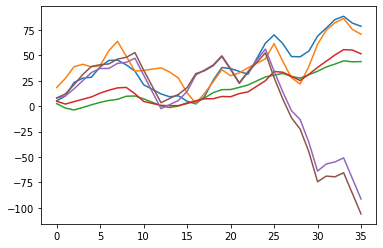

In [893]:
for r in range(6):
    plt.plot(f2[:,r])
#plt.set_title('test3')
plt.title='test12'

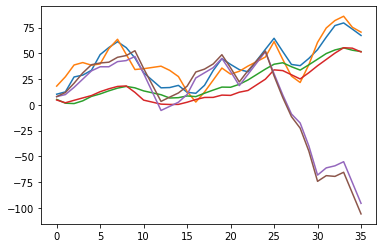

In [890]:
for r in range(6):
    plt.plot(f2[:,r])
#plt.set_title('test3')
plt.title='test11'

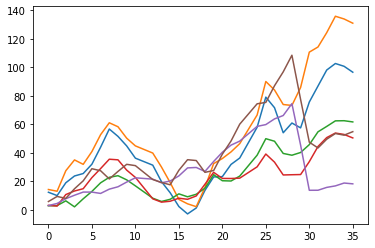

In [887]:
for r in range(6):
    plt.plot(f2[:,r])
#plt.set_title('test3')
plt.title='test10'

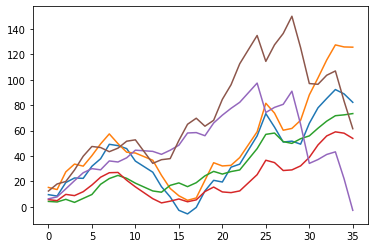

In [885]:
for r in range(6):
    plt.plot(f2[:,r])
#plt.set_title('test3')
plt.title='test9'

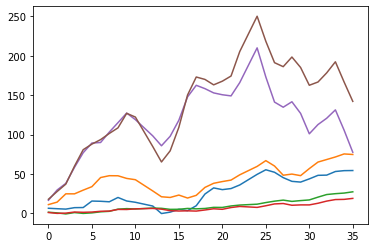

In [882]:
for r in range(6):
    plt.plot(f2[:,r])
#plt.set_title('test3')
plt.title='test8'

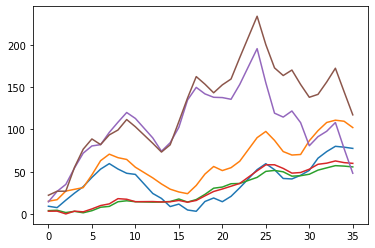

In [879]:
for r in range(6):
    plt.plot(f2[:,r])
#plt.set_title('test3')
plt.title='test7'

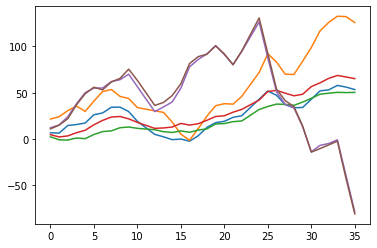

In [872]:
for r in range(6):
    plt.plot(f2[:,r])
#plt.set_title('test3')
plt.title='test6'

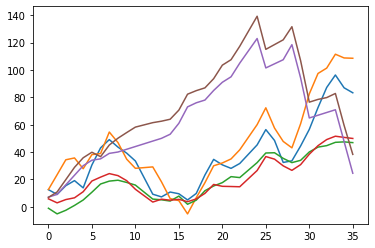

In [870]:
for r in range(6):
    plt.plot(f2[:,r])
#plt.set_title('test3')
plt.title='test3'

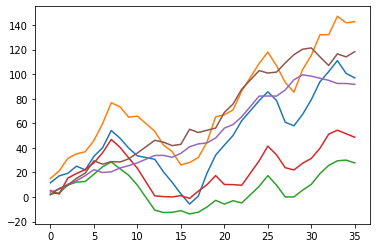

In [861]:
for r in range(6):
    plt.plot(f2[:,r])

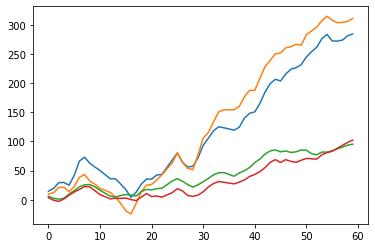

In [856]:
for r in range(4):
    plt.plot(f2[:,r])

In [771]:
np.log2(1)*0.8

0.0

In [777]:
np.e**(0.8)*np.log10(1.5)
10**(1)*np.log10(1.1)
#2**(0.8)*np.log(2.5-1)

0.4139268515822508

In [658]:
for i in range(2013,2019,1):
    for j in range(1,13):
        start_date=datetime(i,j,1) #first day of testing set
        print(start_date)

2013-01-01 00:00:00
2013-02-01 00:00:00
2013-03-01 00:00:00
2013-04-01 00:00:00
2013-05-01 00:00:00
2013-06-01 00:00:00
2013-07-01 00:00:00
2013-08-01 00:00:00
2013-09-01 00:00:00
2013-10-01 00:00:00
2013-11-01 00:00:00
2013-12-01 00:00:00
2014-01-01 00:00:00
2014-02-01 00:00:00
2014-03-01 00:00:00
2014-04-01 00:00:00
2014-05-01 00:00:00
2014-06-01 00:00:00
2014-07-01 00:00:00
2014-08-01 00:00:00
2014-09-01 00:00:00
2014-10-01 00:00:00
2014-11-01 00:00:00
2014-12-01 00:00:00
2015-01-01 00:00:00
2015-02-01 00:00:00
2015-03-01 00:00:00
2015-04-01 00:00:00
2015-05-01 00:00:00
2015-06-01 00:00:00
2015-07-01 00:00:00
2015-08-01 00:00:00
2015-09-01 00:00:00
2015-10-01 00:00:00
2015-11-01 00:00:00
2015-12-01 00:00:00
2016-01-01 00:00:00
2016-02-01 00:00:00
2016-03-01 00:00:00
2016-04-01 00:00:00
2016-05-01 00:00:00
2016-06-01 00:00:00
2016-07-01 00:00:00
2016-08-01 00:00:00
2016-09-01 00:00:00
2016-10-01 00:00:00
2016-11-01 00:00:00
2016-12-01 00:00:00
2017-01-01 00:00:00
2017-02-01 00:00:00


In [641]:
#clf_list = [model1, model2, model3]
eval_scores = [evalscore1, evalscore2, evalscore3, evalscore4, evalscore5, evalscore6, evalscore7, evalscore8, evalscore9]
eval_scores

[8.539091745410117,
 11.124346816409377,
 11.167192226760092,
 9.244380849096924,
 3.9397954705730074,
 10.595257070399821,
 4.134617001377054,
 5.886442409455777,
 1.2478180820867404]

In [651]:
#res[1][:]
#res[1,:][:]
f1 = np.zeros((len(res),4))
f2 = np.zeros((len(res),4))
for i in range(4):
    f1[:,i] = np.array([row[i+1][1] for row in res])
    f2[:,i] = f1[:,i].cumsum()
#f1 = np.array([row[4][1] for row in res])
#f1.cumsum()
f2

array([[  3.8 ,  26.92,   1.68,  -0.58],
       [ 20.42,  60.43,  13.06,   3.87],
       [ 28.89,  71.91,  13.99,   0.45],
       [ 39.53,  94.97,  14.52,   5.37],
       [ 44.45, 109.36,  14.32,   8.81],
       [ 46.66, 102.07,   9.06,   9.54],
       [ 45.9 , 126.29,   0.28,   3.27],
       [ 62.61, 137.07,  12.24,   8.62],
       [ 81.72, 141.85,  24.78,  22.11],
       [ 93.17, 151.79,  33.74,  34.25],
       [101.12, 164.91,  34.06,  36.59],
       [110.47, 175.18,  40.84,  37.6 ],
       [135.47, 209.83,  50.99,  46.97],
       [150.18, 222.79,  51.21,  46.95],
       [170.61, 244.54,  63.77,  56.09],
       [174.93, 262.06,  65.92,  54.49],
       [169.97, 254.54,  65.75,  50.03],
       [166.89, 248.04,  77.14,  59.51]])

In [98]:
pred_test= model1.predict(xgb.DMatrix(xtest,label=None)) 

In [636]:
odds = eval_odds[test_indices]
odds_test_winner = []
data_check_ind =[]
for i in test_indices:
    if i % 2 == 0:
        #odds_test_winner.append(odds[i])
        odds_test_winner.append(eval_odds[i])
        data_check_ind.append(int(i/2))
odds_test_winner

[0.22999999999999998,
 1.44,
 0.22999999999999998,
 1.8599999999999999,
 0.49,
 0.48,
 1.2000000000000002,
 1.0699999999999998,
 0.3600000000000001,
 0.3400000000000001,
 0.3600000000000001,
 0.81,
 0.54,
 0.94,
 1.73,
 0.4099999999999999,
 0.6699999999999999,
 0.69,
 3.0599999999999996,
 0.020000000000000018,
 0.78,
 1.33,
 0.22999999999999998,
 2.3,
 0.030000000000000027,
 2.09,
 1.29,
 1.19,
 0.9299999999999999,
 0.0,
 1.33,
 0.26,
 1.7999999999999998,
 1.23,
 0.3799999999999999,
 0.47,
 1.27,
 1.2000000000000002,
 0.20999999999999996,
 0.3700000000000001,
 1.52,
 1.15,
 0.3500000000000001,
 0.6000000000000001,
 2.5,
 0.74,
 0.42999999999999994,
 0.74,
 0.95,
 0.71,
 0.3899999999999999,
 0.8999999999999999,
 0.75,
 0.24,
 0.3799999999999999,
 0.040000000000000036,
 1.0699999999999998,
 2.24,
 0.21999999999999997,
 0.18999999999999995,
 3.87,
 0.47,
 1.0899999999999999,
 0.6399999999999999,
 1.1800000000000002,
 0.27,
 0.6799999999999999,
 0.56,
 0.9099999999999999,
 1.63,
 0.49,
 0.

In [638]:
data.PSW.iloc[data_check_ind]

29138    1.23
29139    2.44
29140    1.23
29141    2.86
29142    1.49
29143    1.48
29144    2.20
29145    2.07
29146    1.36
29147    1.34
29148    1.36
29149    1.81
29150    1.54
29151    1.94
29152    2.73
29153    1.41
29154    1.67
29155    1.69
29156    4.06
29157    1.02
29158    1.78
29159    2.33
29160    1.23
29161    3.30
29162    1.03
29163    3.09
29164    2.29
29165    2.19
29166    1.93
29167     NaN
         ... 
29608    1.48
29609    1.84
29610    1.52
29611    1.65
29612    1.30
29613    1.52
29614    1.35
29615    1.98
29616    1.68
29617    1.61
29618    1.70
29619    1.74
29620    1.13
29621    2.59
29622    2.86
29623    1.90
29624    1.40
29625    2.33
29626    1.53
29627    2.86
29628    2.12
29629    1.37
29630    2.65
29631    1.52
29632    2.14
29633    2.62
29634    1.60
29635    2.13
29636    3.45
29637    1.71
Name: PSW, Length: 500, dtype: float64

In [58]:
ytest=pd.Series([1,0]*int(len(test_indices)/2))

In [55]:
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder

In [586]:

#clf_list = [model1, model2, model3]
eval_scores = [evalscore1, evalscore2, evalscore3, evalscore4, evalscore5, evalscore6, evalscore7, evalscore8, evalscore9]
eval_scores
print(evalerror(model4.predict(xgb.DMatrix(xtest,label=None)),0))

('test_gain_error', 45.48315697031096)


In [851]:
class VotingClassifier(object):
    """ Implements a voting classifier for pre-trained classifiers"""

    def __init__(self, estimators):
        self.estimators = estimators

    def predict(self, X, thr = 0.5 ,vote_thr = 0.5, conf_thr = 0.5, log_odd_thr = 0.5):
        # get values
        Y = np.zeros([X.shape[0], len(self.estimators)], dtype='float32')
        for i, clf in enumerate(self.estimators):
            if str(type(clf)) == "<class 'xgboost.core.Booster'>":
                preds_in = np.array(clf.predict(xgb.DMatrix(X,label=None)))
                
                preds_dec = np.zeros(len(preds_in))
        
                for k in range(0,len(preds_in)-1,2):
                    if preds_in[k]>preds_in[k+1]:
                        preds_dec[k] = preds_in[k]
                        preds_dec[k+1] = 0
                    else:
                        preds_dec[k] = 0
                        preds_dec[k+1] = preds_in[k+1]
                
                #Y[:, i] = np.array(clf.predict(xgb.DMatrix(X,label=None)))
                Y[:, i] = preds_dec
            else:
                # not further implemented. The Idea was to check if 
                # XGBClassifier gives other / better results
                # the call of it differs to XGB as many others too.
                print('Hallo')
                Y[:, i] = clf.predict_proba(X)
        # apply voting 
        # -------------------------------------------------------
        # log_odd voting
        odds = xtest_0.odds.fillna(1) 
        conf = np.log10(odds)
        Y_log_odd = np.zeros([X.shape[0], len(self.estimators)], dtype='float32')
        for i in range(len(self.estimators)):
            Y_log_odd[:, i] = 10**(Y[:, i]) * conf
            
        # log_odd mean voting    
        y_mean_log_odd = np.zeros(X.shape[0])
        y_mean_pr_log_odd = np.mean(Y_log_odd, axis=1)
        y_mean_log_odd[:] = [1 if i >=log_odd_thr else 0 for i in y_mean_pr_log_odd]  
        
        # log_odd majority voting
        y_voting_log_odd = np.zeros(X.shape[0])
        #y_mer = np.zeros(X.shape[0])
        Y_voting_log_odd = np.zeros([X.shape[0], len(self.estimators)], dtype='int')
        for i in range(len(self.estimators)):  
            #K = np.array([1 if i >=conf_thr else 0 for i in Y[:,i]])
            Y_voting_log_odd[:,i] = [1 if i >=log_odd_thr else 0 for i in Y_log_odd[:,i]]
            
        for i in range(X.shape[0]):
            deci = Y_voting_log_odd[i,:].sum()/len(self.estimators)
            y_voting_log_odd[i] = 1 if deci >= vote_thr else 0
        
        
        
        #---------------------------------------------------------
        # odd confidence voting
        odds = xtest_0.odds.fillna(1)        
        conf = 1/odds        
        Y_conf = np.zeros([X.shape[0], len(self.estimators)], dtype='float32')
        for i in range(len(self.estimators)):
            Y_conf[:, i] = Y[:, i] * conf
            
        # odd conf mean proba voting
        y_mean_conf = np.zeros(X.shape[0])
        y_mean_pr_conf = np.mean(Y_conf, axis=1)
        y_mean_conf[:] = [1 if i >=conf_thr else 0 for i in y_mean_pr_conf]      

        # majority conf voting
        y_voting_conf = np.zeros(X.shape[0])
        y_mer = np.zeros(X.shape[0])
        Y_voting_conf = np.zeros([X.shape[0], len(self.estimators)], dtype='int')
        for i in range(len(self.estimators)):  
            #K = np.array([1 if i >=conf_thr else 0 for i in Y[:,i]])
            Y_voting_conf[:,i] = [1 if i >=conf_thr else 0 for i in Y_conf[:,i]]
            
        for i in range(X.shape[0]):
            deci = Y_voting_conf[i,:].sum()/len(self.estimators)
            y_voting_conf[i] = 1 if deci >= vote_thr else 0
            
        
        #-----------------------------------------------------------
        # mean proba voting
        y_mean = np.zeros(X.shape[0])
        y_mean_pr = np.mean(Y, axis=1)
        y_mean[:] = [1 if i >=thr else 0 for i in y_mean_pr]
        
        # majority voting
        y_voting = np.zeros(X.shape[0])
        y_mer = np.zeros(X.shape[0])
        Y_voting = np.zeros([X.shape[0], len(self.estimators)], dtype='int')
        for i in range(len(self.estimators)):  
            K = np.array([1 if i >=thr else 0 for i in Y[:,i]])
            Y_voting[:,i] = [1 if i >=thr else 0 for i in Y[:,i]]
            
        for i in range(X.shape[0]):
            deci = Y_voting[i,:].sum()/len(self.estimators)
            y_voting[i] = 1 if deci >= vote_thr else 0
            #y_mer[]
         
        #return Y, K, KT, y_mean_pr, y_mean, Y_voting, y_voting, deci, y_mean_pr_conf, y_mean_conf
        #return  y_mean,  y_voting, y_mean_pr_conf, y_mean_conf, y_voting_conf
        return  y_mean,  y_voting, y_mean_conf, y_voting_conf, y_mean_log_odd, y_voting_log_odd
        #return y, Y, K, KT

In [844]:
clf_list = [model1, model2, model3, model4, model5, model6, model7, model8, model9]
classif = VotingClassifier(clf_list)
xtest_0=features.iloc[test_indices,:].reset_index(drop=True)
#Y, K, KT, y_mean_pr, y_mean, Y_voting, y_voting, deci, y_mean_pr_conf, y_mean_conf= classif.predict(xtest, 0.7, vote_thr = (7/9))
y_mean,  y_voting, y_mean_conf, y_voting_conf, y_mean_log_odd, y_voting_log_odd = classif.predict(xtest, 0.6, log_odd_thr = 1.6, vote_thr = (7/9), conf_thr = 0.6)


print(evalerror(y_voting, dtrain)[1])
print(evalerror(y_mean, dtrain))
print(evalerror(y_mean_conf, dtrain))
print(evalerror(y_voting_conf, dtrain))
print(evalerror(y_mean_log_odd, dtrain))
print(evalerror(y_voting_log_odd, dtrain))

3.2399999999999975
('test_o_gain_error', 5.109999999999997)
('test_o_gain_error', 3.969999999999999)
('test_o_gain_error', 1.699999999999999)
('test_o_gain_error', -2.1399999999999997)
('test_o_gain_error', -2.03)


In [817]:
((-0.1/np.log10(0.55)) + (-0.1/np.log10(0.8))+ (-0.1/np.log10(0.55)))/3
np.sqrt(((0.3)**2 + (0.7)**2)/2)
(0.3 + 0.7)/2

0.5

In [846]:
y_voting_log_odd.sum()

3.0

In [249]:
from sklearn.metrics import confusion_matrix

In [466]:
cnf_matrix = confusion_matrix(ytest, y_voting)
cnf_matrix

array([[1840,  160],
       [1318,  682]])

In [351]:
evalerror(y_voting, dtrain)

('test_gain_error', -5.280000000000001)

In [ ]:
class VotingClassifier(object):
    """ Implements a voting classifier for pre-trained classifiers"""

    def __init__(self, estimators):
        self.estimators = estimators

    def predict(self, X, thr = 0.5 ,vote_thr = 0.5):
        # get values
        Y = np.zeros([X.shape[0], len(self.estimators)], dtype='float32')
        for i, clf in enumerate(self.estimators):
            if str(type(clf)) == "<class 'xgboost.core.Booster'>":              
                Y[:, i] = np.array(clf.predict(xgb.DMatrix(X,label=None)))
            else:
                print('Hallo')
                Y[:, i] = clf.predict_proba(X)
        # apply voting 
        
        # mean proba voting
        
        y_mean = np.zeros(X.shape[0])
        y_mean_pr = np.mean(Y, axis=1)
        y_mean = [1 if i >=thr else 0 for i in y_mean_pr]
        
        
        y_voting = np.zeros(X.shape[0])
        y_mer = np.zeros(X.shape[0])
        Y_voting = np.zeros([X.shape[0], len(self.estimators)], dtype='int')
        for i in range(len(self.estimators)):  
            K = np.array([1 if i >=thr else 0 for i in Y[:,i]])
            Y_voting[:,i] = [1 if i >=thr else 0 for i in Y[:,i]]
            
        for i in range(X.shape[0]):
            deci = Y_voting[i,:].sum()/len(self.estimators)
            y_voting[i] = 1 if deci >= vote_thr else 0
            #y_mer[]
         
        return Y, K, KT, y_mean_pr, y_mean, Y_voting, y_voting, deci
        #return y, Y, K, KT

In [732]:
def evalerror(preds, dtrain):
#thr = 0.5
    #labels = dtrain.get_label()
    global eval_odds
    global train_indices
    global val_indices
    global test_indices
    
    #print(preds[0:10])


    if len(preds) == len(train_indices):
        odds = eval_odds[train_indices]
        gain = odds * preds       
        return 'train_gain_error', -gain.sum()
    elif len(preds) == len(val_indices):
        odds = eval_odds[val_indices]
        gain = odds * preds 
        return 'val_gain_error', -gain.sum()
    elif len(preds) == len(test_indices):
        odds = eval_odds[test_indices]
        gain = odds * preds 
        #return 'test_o_gain_error', -gain.sum(), odds
        return 'test_o_gain_error', -gain.sum()
    else:
        return 'function_error', 0

In [540]:
features.columns

Index(['odds', 'odds_opp', 'cat_feature_0', 'cat_feature_1', 'cat_feature_2',
       'cat_feature_3', 'cat_feature_4', 'cat_feature_5', 'cat_feature_6',
       'cat_feature_7',
       ...
       'recentft_150_1_opp', 'recentft_150_2_opp', 'recentft_150_3_opp',
       'recentft_150_4_opp', 'recentft_150_5_opp', 'recentft_150_6_opp',
       'recentft_150_7_opp', 'recentft_150_8_opp', 'recentft_150_9_opp',
       'recentft_150_10_opp'],
      dtype='object', length=246)